# 데이터 전처리


In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Lion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#패키지 import

In [ ]:
# @title
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#폰트 설치
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')

In [ ]:
df = df.set_index('관측일시')#인덱스로 설정

In [ ]:
#데이터 분리
target=['가뭄(MSWSI)','가뭄(SPI6)']
X=df.drop(target,axis=1)
y=df[target]


In [ ]:
# y[target] = y[target].replace({ 2: '극한습윤', 1.5: '심한습윤', 1: '보통습윤', 0.5: '약한습윤',0: '정상', -0.5: '약한가뭄', -1: '보통가뭄', -1.5: '심한가뭄', -2: '극한가뭄'})
# y[target] = y[target].astype('category')
# display(y[target])
# y.info()

In [ ]:
#train, test 데이터 나누기
test_size = 52#24년 데이터 개수
X_train, X_test = X[:-test_size], X[-test_size:]#독립변수 분할
y_train, y_test = y[:-test_size], y[-test_size:]#종속변수 분할

In [ ]:
from sklearn.preprocessing import RobustScaler
#스케일러 적용
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust = scaler_robust.transform(X_test)#test는 fit하지 않습니다(데이터누수 때문에)

#dataframe으로 변환
X_train_robust   = pd.DataFrame(X_train_robust, columns=X_train.columns, index=X_train.index)
X_test_robust    = pd.DataFrame(X_test_robust, columns=X_test.columns, index=X_test.index)

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse_output=False)
# y_train_ohe  = ohe.fit_transform(y_train[['가뭄(MSWSI)', '가뭄(SPI6)']])
# y_test_ohe  = ohe.transform(y_test[['가뭄(MSWSI)', '가뭄(SPI6)']])#test는 fit하지 않습니다(데이터누수 때문에)
# encoded_y_train = pd.DataFrame(y_train_ohe, columns=ohe.get_feature_names_out(), index=y_train.index)
# encoded_y_test = pd.DataFrame(y_test_ohe, columns=ohe.get_feature_names_out(), index=y_test.index)
# display(encoded_y_train)
# display(encoded_y_test)

# 변수설명
X_train=독립변수 훈련데이터\
X_test=독립변수 테스트데이터\
y_test=종속변수 테스트데이터(원핫인코딩x)\
y_train=종속변수 훈련데이터(원핫인코딩x)\
encoded_y_train=종속변수 테스트데이터(원핫인코딩o)\
encoded_y_test=종속변수 테스트데이터(원핫인코딩o)\
=================================================\
훈련데이터는 X_train_robust,encoded_y_train 사용\
테스트 데이터는 X_test_robust,encoded_y_test 사용


# 기본모델(사실상 0.5 범위 예측이라고 보면됨)

LSTM 모델

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# 데이터 준비
# -----------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target]

# train/test 분할
test_size = 52
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# 스케일링
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

# -----------------------------
# 라벨 인코딩 (y 값: -2 ~ 2, 0.5 단위)
# -----------------------------
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

# -----------------------------
# 시퀀스 데이터셋 생성
# -----------------------------
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:i+time_steps].values)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12  # 최근 12주 데이터를 입력으로 사용
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_enc, time_steps)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled, y_test_enc, time_steps)

print("X_train_seq:", X_train_seq.shape)
print("y_train_seq:", y_train_seq.shape)

# -----------------------------
# LSTM 모델 정의
# -----------------------------
model = Sequential([
    LSTM(64, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# -----------------------------
# 학습
# -----------------------------
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

# -----------------------------
# 평가
# -----------------------------
y_pred = model.predict(X_test_seq).argmax(axis=1)

print("분류 보고서:\n", classification_report(y_test_seq, y_pred, target_names=le.classes_.astype(str)))
print("혼동행렬:\n", confusion_matrix(y_test_seq, y_pred))


X_train_seq: (562, 12, 5)
y_train_seq: (562,)
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2283 - loss: 1.9732 - val_accuracy: 0.2124 - val_loss: 1.8823
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3399 - loss: 1.6245 - val_accuracy: 0.1858 - val_loss: 1.6222
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4059 - loss: 1.4286 - val_accuracy: 0.1593 - val_loss: 1.5261
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4015 - loss: 1.4326 - val_accuracy: 0.2389 - val_loss: 1.5206
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4261 - loss: 1.3518 - val_accuracy: 0.3628 - val_loss: 1.5162
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4752 - loss: 1.3288 - val_accuracy: 0.3451 - val_loss: 1.5023
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4344 - loss: 1.3201 - val_accuracy: 0.3274 - val_loss: 1.5232
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4968 - loss: 1.2794 - val_accuracy: 0.3097 - val_los

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


회귀 LSTM — 연속값 예측 후 0.5 간격으로 반올림하여 분류 성능 확인

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix

# --- 설정 ---
time_steps = 12  # 필요하면 8, 16 등으로 실험
batch_size = 16
epochs = 100

# y를 숫자(실수)로 유지
y_train_vals = y_train.values.astype(float)
y_test_vals  = y_test.values.astype(float)

def create_sequences_reg(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences_reg(X_train_scaled, y_train_vals, time_steps)
X_test_seq,  y_test_seq  = create_sequences_reg(X_test_scaled,  y_test_vals,  time_steps)

print("Train samples:", X_train_seq.shape, "Test samples:", X_test_seq.shape)

# --- 모델(회귀) ---
model_reg = Sequential([
    LSTM(64, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_reg.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)

# --- 평가 (연속값) ---
y_pred_cont = model_reg.predict(X_test_seq).flatten()
print("RMSE:", np.sqrt(mean_squared_error(y_test_seq, y_pred_cont)))
print("MAE:", mean_absolute_error(y_test_seq, y_pred_cont))

# --- 연속 -> 0.5 단위 반올림하여 분류로 변환 ---
y_pred_round = np.round(y_pred_cont * 2) / 2.0  # 0.5 단위 반올림
y_test_round = np.round(y_test_seq * 2) / 2.0

# 문자열로 바꿔서 classification_report에 쓰면 라벨 누락 문제 줄어듬
y_pred_s = y_pred_round.astype(str)
y_test_s  = y_test_round.astype(str)

print("분류 보고서 (회귀->라운드):")
print(classification_report(y_test_s, y_pred_s))
print("혼동행렬:")
print(confusion_matrix(y_test_s, y_pred_s))


Train samples: (562, 12, 5) Test samples: (40, 12, 5)
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3098 - mae: 0.4371 - val_loss: 0.4410 - val_mae: 0.5432
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2948 - mae: 0.4376 - val_loss: 0.4591 - val_mae: 0.5284
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2365 - mae: 0.3797 - val_loss: 0.4539 - val_mae: 0.5451
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2270 - mae: 0.3822 - val_loss: 0.4349 - val_mae: 0.5162
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2441 - mae: 0.3853 - val_loss: 0.4360 - val_mae: 0.5427
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2228 - mae: 0.3656 - val_loss: 0.4205 - val_mae: 0.5122
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2041 - mae: 0.3424 - val_loss: 0.4456 - val_mae: 0.5428
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2077 - mae: 0.3508 - val_loss: 0.4250 - val_mae: 0.5320
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2225 - ma

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

분류로 구조를 바꿔서 다시 시도

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target]

# 스케일링
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ------------------------
# y 라벨 인코딩 + one-hot
# ------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1]

# ------------------------
# Train/Test 분리 (마지막 52주)
# ------------------------
test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y_categorical[:-test_size], y_categorical[-test_size:]
y_test_labels = np.argmax(y_test_raw, axis=1)

# ------------------------
# 시퀀스 생성 (time_steps = 12주)
# ------------------------
time_steps = 12
def create_sequences(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq,  y_test_seq  = create_sequences(X_test_raw,  y_test_raw,  time_steps)
y_test_labels_seq = np.argmax(y_test_seq, axis=1)  # 평가용 라벨

print("Train X shape:", X_train_seq.shape)
print("Train y shape:", y_train_seq.shape)
print("Test X shape:", X_test_seq.shape)
print("Test y shape:", y_test_seq.shape)

# ------------------------
# LSTM 모델 정의
# ------------------------
model = Sequential([
    LSTM(64, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------------
# 학습
# ------------------------
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

# ------------------------
# 평가
# ------------------------
y_pred_probs = model.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

print("Accuracy:", accuracy_score(y_test_labels_seq, y_pred_labels))
print("Classification Report:")
print(classification_report(y_test_labels_seq, y_pred_labels, target_names=le.classes_.astype(str)))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels_seq, y_pred_labels))


Train X shape: (562, 12, 5)
Train y shape: (562, 8)
Test X shape: (40, 12, 5)
Test y shape: (40, 8)
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.2686 - loss: 1.9520 - val_accuracy: 0.3805 - val_loss: 1.7844
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4120 - loss: 1.5864 - val_accuracy: 0.1593 - val_loss: 1.6518
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3956 - loss: 1.4249 - val_accuracy: 0.3717 - val_loss: 1.4731
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4167 - loss: 1.3968 - val_accuracy: 0.2566 - val_loss: 1.5348
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4421 - loss: 1.3730 - val_accuracy: 0.3717 - val_loss: 1.4924
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4757 - loss: 1.3455 - val_accuracy: 0.2655 - val_loss: 1.5742
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4412 - loss: 1.2990 - val_accuracy: 0.3274 - val_loss: 1.5738
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4633 - loss: 1.3358 - val_accuracy: 0.2832 - val_loss: 1.

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Accuracy: 0.375
Classification Report:
              precision    recall  f1-score   support

        -1.5       0.00      0.00      0.00         1
        -1.0       0.00      0.00      0.00         7
        -0.5       0.39      1.00      0.57        15
         0.0       0.00      0.00      0.00         8
         0.5       0.00      0.00      0.00         4
         1.0       0.00      0.00      0.00         2
         1.5       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00         1

    accuracy                           0.38        40
   macro avg       0.05      0.12      0.07        40
weighted avg       0.15      0.38      0.21        40

Confusion Matrix:
[[ 0  0  1  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0]
 [ 0  0  8  0  0  0  0  0]
 [ 0  0  3  1  0  0  0  0]
 [ 0  0  2  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


분류용 LSTM에 class_weight를 적용해서 소수 클래스도 학습에 반영

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target]

# 스케일링
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ------------------------
# y 라벨 인코딩 + one-hot
# ------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)
num_classes = y_categorical.shape[1]

# ------------------------
# Train/Test 분리 (마지막 52주)
# ------------------------
test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y_categorical[:-test_size], y_categorical[-test_size:]
y_test_labels = np.argmax(y_test_raw, axis=1)

# ------------------------
# 시퀀스 생성 (time_steps = 12주)
# ------------------------
time_steps = 12
def create_sequences(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq,  y_test_seq  = create_sequences(X_test_raw,  y_test_raw,  time_steps)
y_test_labels_seq = np.argmax(y_test_seq, axis=1)  # 평가용 라벨

print("Train X shape:", X_train_seq.shape)
print("Train y shape:", y_train_seq.shape)
print("Test X shape:", X_test_seq.shape)
print("Test y shape:", y_test_seq.shape)

# ------------------------
# class_weight 계산
# ------------------------
classes = np.arange(num_classes)
y_train_labels_seq = np.argmax(y_train_seq, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_labels_seq)
class_weight_dict = dict(enumerate(class_weights))
print("class_weight:", class_weight_dict)

# ------------------------
# LSTM 모델 정의
# ------------------------
model = Sequential([
    LSTM(64, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------------
# 학습
# ------------------------
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    class_weight=class_weight_dict,
    verbose=1
)

# ------------------------
# 평가
# ------------------------
y_pred_probs = model.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

print("Accuracy:", accuracy_score(y_test_labels_seq, y_pred_labels))
print("Classification Report:")
print(classification_report(y_test_labels_seq, y_pred_labels, target_names=le.classes_.astype(str)))
print("Confusion Matrix:")
print(confusion_matrix(y_test_labels_seq, y_pred_labels))


Train X shape: (562, 12, 5)
Train y shape: (562, 8)
Test X shape: (40, 12, 5)
Test y shape: (40, 8)
class_weight: {0: np.float64(23.416666666666668), 1: np.float64(0.5242537313432836), 2: np.float64(0.3991477272727273), 3: np.float64(0.3902777777777778), 4: np.float64(1.5965909090909092), 5: np.float64(3.9027777777777777), 6: np.float64(14.05), 7: np.float64(35.125)}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2339 - loss: 1.6430 - val_accuracy: 0.2389 - val_loss: 1.9862
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2225 - loss: 2.1259 - val_accuracy: 0.1150 - val_loss: 2.0038
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1572 - loss: 1.7000 - val_accuracy: 0.0354 - val_loss: 2.0448
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1362 - loss: 1.8071 - val_accuracy: 0.0177 - val_loss: 2.0614
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1307 - loss: 2.0214 - val_accuracy: 0.0265 - val_loss: 2.0884
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1149 - loss: 1.5365 - val_accuracy: 0.0885 - val_loss: 2.0643
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1226 - loss: 1.4633 - val_accuracy: 0.0708 - val_loss: 2.0398
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1543 - loss: 1.4055 - val_accuracy: 0.1062 - val_loss

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


회귀 LSTM을 기준으로

RMSE, MAE

그리고 ±0.5 단계 근접 정확도

Train X shape: (562, 12, 5)
Train y shape: (562,)
Test X shape: (40, 12, 5)
Test y shape: (40,)
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.3348 - mae: 0.4560 - val_loss: 0.4095 - val_mae: 0.5246
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.3076 - mae: 0.4285 - val_loss: 0.4341 - val_mae: 0.5285
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2456 - mae: 0.3886 - val_loss: 0.4499 - val_mae: 0.5399
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2673 - mae: 0.4163 - val_loss: 0.4331 - val_mae: 0.5410
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2239 - mae: 0.3763 - val_loss: 0.4332 - val_mae: 0.5308
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2213 - mae: 0.3602 - val_loss: 0.4263 - val_mae: 0.5343
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2357 - mae: 0.3905 - val_loss: 0.4056 - val_mae: 0.5159
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2212 - mae: 0.3579 - val_loss: 0.4058 - val_mae: 0.5206
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2592 - mae

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


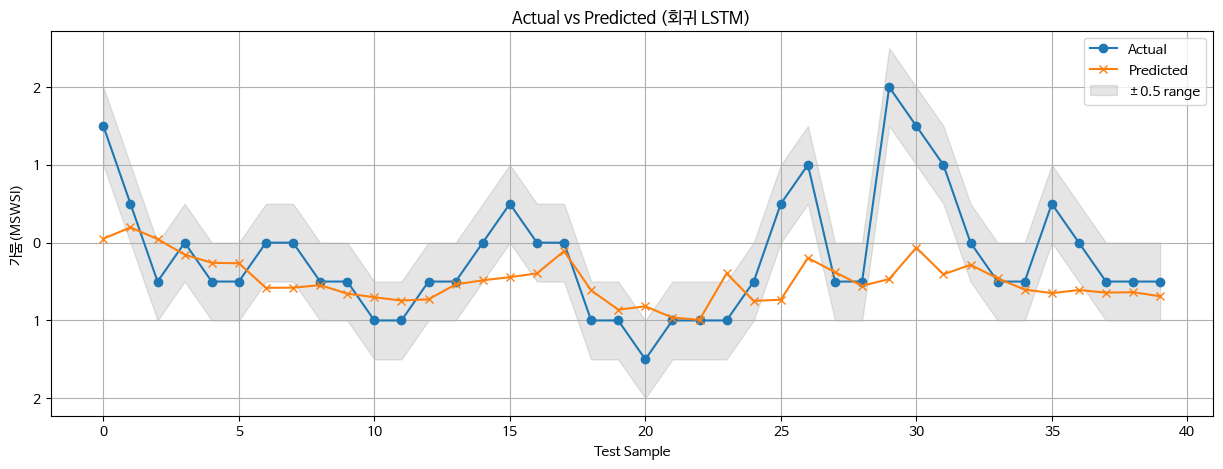

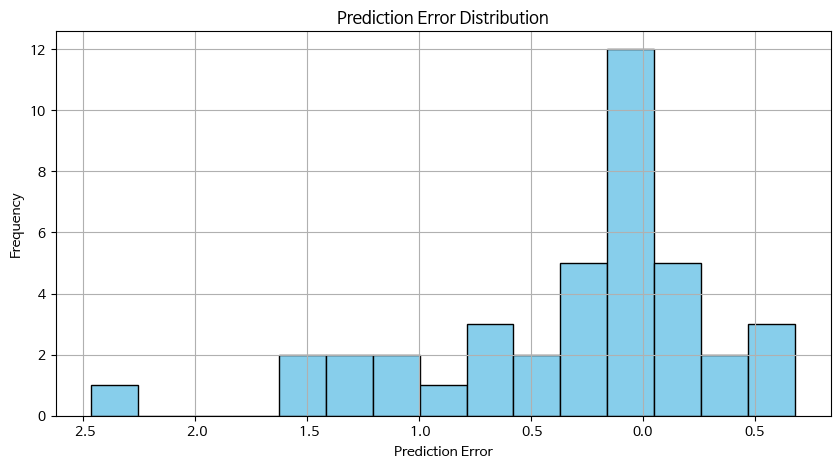

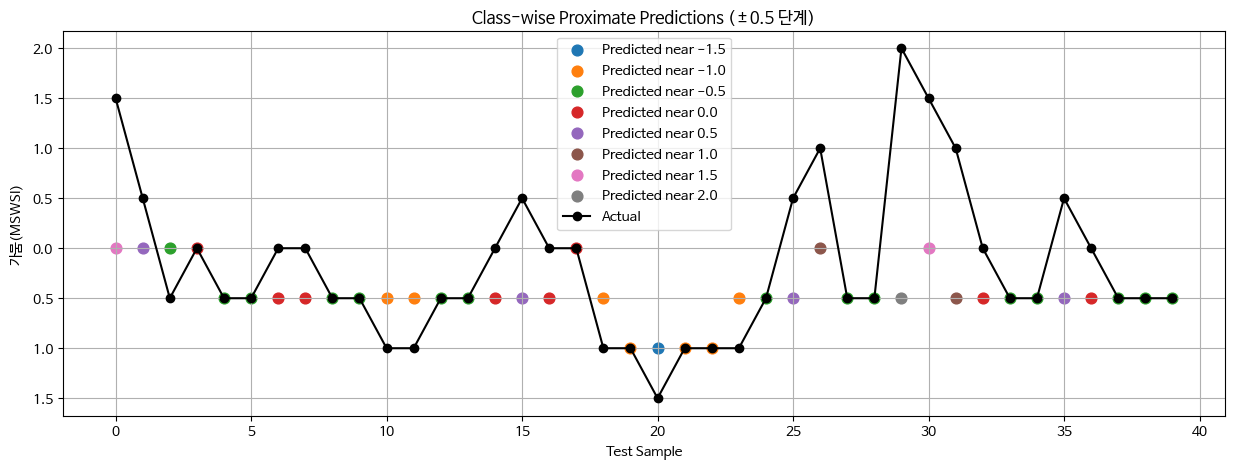

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target].values.astype(float)

# 스케일링
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ------------------------
# Train/Test 분리 (마지막 52주)
# ------------------------
test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y[:-test_size], y[-test_size:]

# ------------------------
# 시퀀스 생성 (time_steps = 12주)
# ------------------------
time_steps = 12
def create_sequences_reg(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences_reg(X_train_raw, y_train_raw, time_steps)
X_test_seq,  y_test_seq  = create_sequences_reg(X_test_raw,  y_test_raw,  time_steps)

print("Train X shape:", X_train_seq.shape)
print("Train y shape:", y_train_seq.shape)
print("Test X shape:", X_test_seq.shape)
print("Test y shape:", y_test_seq.shape)

# ------------------------
# LSTM 회귀 모델 정의
# ------------------------
model = Sequential([
    LSTM(64, input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ------------------------
# 학습
# ------------------------
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[es],
    verbose=1
)

# ------------------------
# 평가
# ------------------------
y_pred_cont = model.predict(X_test_seq).flatten()

# RMSE, MAE
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_cont))
mae  = mean_absolute_error(y_test_seq, y_pred_cont)
print("RMSE:", rmse)
print("MAE:", mae)

# ±0.5 단계 근접 정확도
y_pred_round = np.round(y_pred_cont * 2) / 2.0
y_test_round = np.round(y_test_seq * 2) / 2.0
prox_acc = np.mean(np.abs(y_test_round - y_pred_round) <= 0.5)
print("근접 정확도 (±0.5 단계):", prox_acc)

# 클래스별 근접 평가 (optional)
for cls in np.unique(y_test_round):
    idx = y_test_round == cls
    cls_acc = np.mean(np.abs(y_pred_round[idx] - cls) <= 0.5)
    print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")


import matplotlib.pyplot as plt

# ------------------------
# 실제 vs 예측
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(y_test_seq, label='Actual', marker='o')
plt.plot(y_pred_cont, label='Predicted', marker='x')

# ±0.5 단계 범위
plt.fill_between(range(len(y_test_seq)),
                 y_test_seq - 0.5,
                 y_test_seq + 0.5,
                 color='gray', alpha=0.2, label='±0.5 range')

plt.xlabel('Test Sample')
plt.ylabel('가뭄(MSWSI)')
plt.title('Actual vs Predicted (회귀 LSTM)')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------
# 오차 분포 히스토그램
# ------------------------
errors = y_pred_cont - y_test_seq
plt.figure(figsize=(10,5))
plt.hist(errors, bins=15, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.grid(True)
plt.show()

# ------------------------
# 클래스별 근접 예측 표시
# ------------------------
plt.figure(figsize=(15,5))
for cls in np.unique(y_test_round):
    idx = y_test_round == cls
    plt.scatter(np.where(idx)[0], y_pred_round[idx], label=f'Predicted near {cls}', s=60)

plt.plot(y_test_round, label='Actual', color='black', marker='o')
plt.xlabel('Test Sample')
plt.ylabel('가뭄(MSWSI)')
plt.title('Class-wise Proximate Predictions (±0.5 단계)')
plt.legend()
plt.grid(True)
plt.show()


위 모델보다 성능을 상승시킴

현재 단계에서 MSWSI 모델중 제일 성능 좋음

Original train samples: 562
After oversampling: 834


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 12, 128)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,313 (333.25 KB)

 Trainable params: 85,313 (333.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.4885 - mae: 0.5781 - val_loss: 0.9197 - val_mae: 0.8222 - learning_rate: 0.0010
Epoch 2/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.4116 - mae: 0.5291 - val_loss: 0.8870 - val_mae: 0.7870 - learning_rate: 0.0010
Epoch 3/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3541 - mae: 0.4809 - val_loss: 1.0398 - val_mae: 0.8787 - learning_rate: 0.0010
Epoch 4/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3656 - mae: 0.4804 - val_loss: 0.8742 - val_mae: 0.7339 - learning_rate: 0.0010
Epoch 5/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3276 - mae: 0.4636 - val_loss: 0.9188 - val_mae: 0.7568 - learning_rate: 0.0010
Epoch 6/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2463 - mae: 0.3941 - val_loss: 0.9094 - val_mae: 0.7669 - learning_rate: 0.0010
Epoch 7/150
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.2698 - mae: 0.4155 - val_loss: 0.9860 - val_mae: 0.7889 - learning_rate: 0.0010
Epoch 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


RMSE: 0.7428417955893402
MAE: 0.5672875500284136
근접 정확도 (±0.5 단계): 0.75
Class -1.5: 근접 정확도 ±0.5 = 0.00
Class -1.0: 근접 정확도 ±0.5 = 0.57
Class -0.5: 근접 정확도 ±0.5 = 1.00
Class 0.0: 근접 정확도 ±0.5 = 1.00
Class 0.5: 근접 정확도 ±0.5 = 0.50
Class 1.0: 근접 정확도 ±0.5 = 0.50
Class 1.5: 근접 정확도 ±0.5 = 0.00
Class 2.0: 근접 정확도 ±0.5 = 0.00


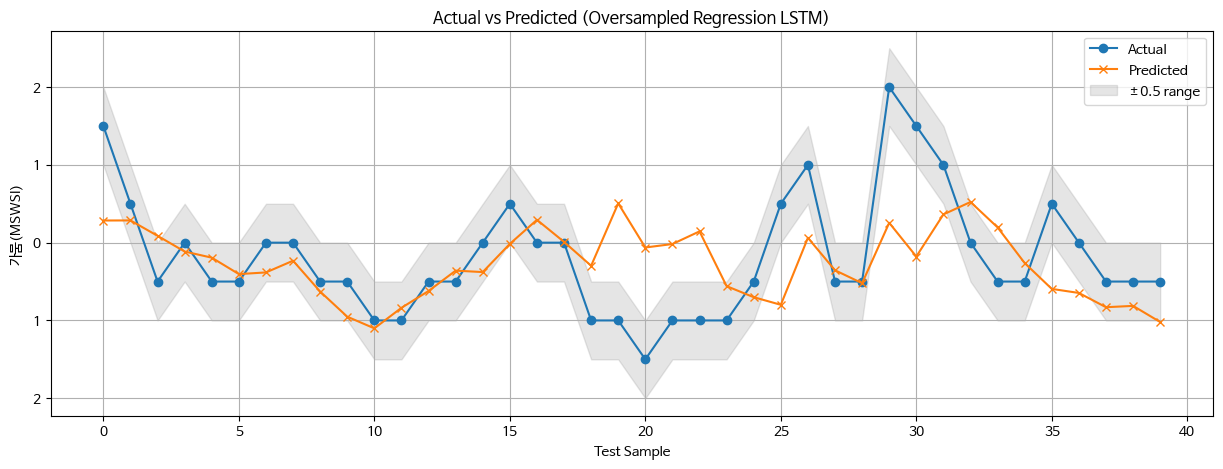

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target].values.astype(float)

# 스케일링
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ------------------------
# Train/Test 분리
# ------------------------
test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y[:-test_size], y[-test_size:]

# ------------------------
# 시퀀스 생성 함수
# ------------------------
def create_sequences(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, time_steps)

# ------------------------
# 소수/양수 클래스 oversampling
# ------------------------
def oversample_sequences(X_seq, y_seq, factor_dict):
    X_new, y_new = [], []
    for cls, factor in factor_dict.items():
        idx = np.where(y_seq == cls)[0]
        for i in idx:
            for _ in range(factor):
                X_new.append(X_seq[i][np.newaxis, :, :])  # 3D 유지
                y_new.append(y_seq[i].reshape(1,1))       # 2D 유지
    if X_new:
        X_new = np.concatenate([X_seq] + X_new, axis=0)
        y_new = np.concatenate([y_seq.reshape(-1,1)] + y_new, axis=0).flatten()
    else:
        X_new, y_new = X_seq, y_seq
    return X_new, y_new

# 클래스별 복제 비율
factor_dict = {-1.5: 5, 1.0: 5, 1.5: 5, 2.0: 5, 0.5: 3}
X_train_seq_bal, y_train_seq_bal = oversample_sequences(X_train_seq, y_train_seq, factor_dict)

print("Original train samples:", X_train_seq.shape[0])
print("After oversampling:", X_train_seq_bal.shape[0])

# ------------------------
# LSTM 모델 정의
# ------------------------
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# ------------------------
# 학습
# ------------------------
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)

history = model.fit(
    X_train_seq_bal, y_train_seq_bal,
    validation_split=0.2,
    epochs=150,
    batch_size=8,
    callbacks=[es, rlr],
    verbose=1
)

# ------------------------
# 평가
# ------------------------
y_pred_cont = model.predict(X_test_seq).flatten()

# RMSE, MAE
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_cont))
mae  = mean_absolute_error(y_test_seq, y_pred_cont)
print("RMSE:", rmse)
print("MAE:", mae)

# ±0.5 단계 근접 정확도
y_pred_round = np.round(y_pred_cont * 2) / 2.0
y_test_round = np.round(y_test_seq * 2) / 2.0
prox_acc = np.mean(np.abs(y_test_round - y_pred_round) <= 0.5)
print("근접 정확도 (±0.5 단계):", prox_acc)

# 클래스별 근접 정확도
for cls in np.unique(y_test_round):
    idx = y_test_round == cls
    cls_acc = np.mean(np.abs(y_pred_round[idx] - cls) <= 0.5)
    print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")

# ------------------------
# 시각화: 실제 vs 예측
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(y_test_seq, label='Actual', marker='o')
plt.plot(y_pred_cont, label='Predicted', marker='x')
plt.fill_between(range(len(y_test_seq)),
                 y_test_seq - 0.5, y_test_seq + 0.5,
                 color='gray', alpha=0.2, label='±0.5 range')
plt.xlabel('Test Sample')
plt.ylabel('가뭄(MSWSI)')
plt.title('Actual vs Predicted (Oversampled Regression LSTM)')
plt.legend()
plt.grid(True)
plt.show()


더 성능을 좋게 하기 위한 작업

Original train samples: 562
After oversampling: 1378


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 12, 128)        │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,153 (285.75 KB)

 Trainable params: 73,153 (285.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.2492 - mae: 0.4453 - val_loss: 1.1505 - val_mae: 0.9926 - learning_rate: 0.0010
Epoch 2/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1904 - mae: 0.3742 - val_loss: 1.2442 - val_mae: 1.0749 - learning_rate: 0.0010
Epoch 3/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1649 - mae: 0.3473 - val_loss: 1.1534 - val_mae: 1.0140 - learning_rate: 0.0010
Epoch 4/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1345 - mae: 0.3132 - val_loss: 0.7520 - val_mae: 0.6693 - learning_rate: 0.0010
Epoch 5/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.1459 - mae: 0.3326 - val_loss: 0.8881 - val_mae: 0.7934 - learning_rate: 0.0010
Epoch 6/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1348 - mae: 0.3132 - val_loss: 0.8602 - val_mae: 0.7563 - learning_rate: 0.0010
Epoch 7/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1192 - mae: 0.2961 - val_loss: 0.8505 - val_mae: 0.7681 - learning_rate:

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


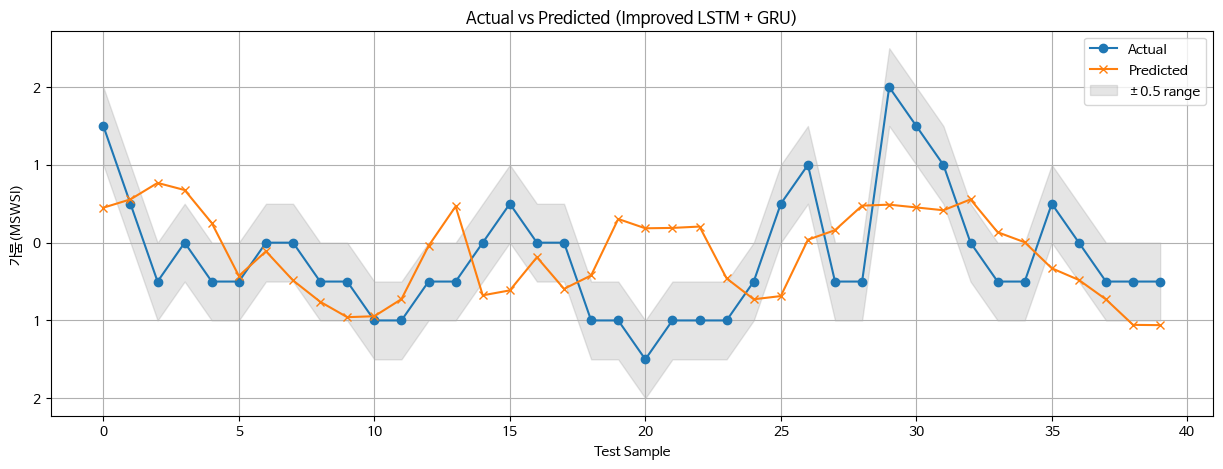

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target].values.astype(float)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ------------------------
# Train/Test 분리
# ------------------------
test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y[:-test_size], y[-test_size:]

# ------------------------
# 시퀀스 생성 함수
# ------------------------
def create_sequences(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, time_steps)

# ------------------------
# 시퀀스 oversampling + 노이즈 추가
# ------------------------
def oversample_sequences(X_seq, y_seq, factor_dict, noise_std=0.01):
    X_new, y_new = [], []
    for cls, factor in factor_dict.items():
        idx = np.where(y_seq == cls)[0]
        for i in idx:
            for _ in range(factor):
                # np.newaxis로 3D 변환 + 노이즈 추가
                X_aug = X_seq[i][np.newaxis, :, :] + np.random.normal(0, noise_std, X_seq[i].shape)[np.newaxis, :, :]
                X_new.append(X_aug)
                y_new.append(y_seq[i].reshape(1,1))
    if X_new:
        X_new = np.concatenate([X_seq] + X_new, axis=0)
        y_new = np.concatenate([y_seq.reshape(-1,1)] + y_new, axis=0).flatten()
    else:
        X_new, y_new = X_seq, y_seq
    return X_new, y_new

factor_dict = {-1.5:5, -1.0:2, -0.5:1, 0.0:1, 0.5:2, 1.0:3, 1.5:5, 2.0:5}
X_train_seq_bal, y_train_seq_bal = oversample_sequences(X_train_seq, y_train_seq, factor_dict)

print("Original train samples:", X_train_seq.shape[0])
print("After oversampling:", X_train_seq_bal.shape[0])

# ------------------------
# LSTM + GRU 모델 정의
# ------------------------
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss=Huber(delta=0.5), metrics=['mae'])
model.summary()

# ------------------------
# 학습
# ------------------------
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)

# 클래스별 sample_weight
class_weights_dict = {-1.5:5, -1.0:2, -0.5:1, 0.0:1, 0.5:2, 1.0:3, 1.5:5, 2.0:5}
sample_weights = np.array([class_weights_dict.get(y,1) for y in y_train_seq_bal])

history = model.fit(
    X_train_seq_bal, y_train_seq_bal,
    validation_split=0.2,
    sample_weight=sample_weights,
    epochs=150,
    batch_size=8,
    callbacks=[es, rlr],
    verbose=1
)

# ------------------------
# 평가
# ------------------------
y_pred_cont = model.predict(X_test_seq).flatten()
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_cont))
mae  = mean_absolute_error(y_test_seq, y_pred_cont)
print("RMSE:", rmse)
print("MAE:", mae)

# ±0.5 단계 근접 정확도
y_pred_round = np.round(y_pred_cont * 2)/2
y_test_round = np.round(y_test_seq * 2)/2
prox_acc = np.mean(np.abs(y_test_round - y_pred_round) <= 0.5)
print("근접 정확도 (±0.5 단계):", prox_acc)

# 클래스별 근접 정확도
for cls in np.unique(y_test_round):
    idx = y_test_round == cls
    cls_acc = np.mean(np.abs(y_pred_round[idx] - cls) <= 0.5)
    print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")

# ------------------------
# 시각화
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(y_test_seq, label='Actual', marker='o')
plt.plot(y_pred_cont, label='Predicted', marker='x')
plt.fill_between(range(len(y_test_seq)), y_test_seq-0.5, y_test_seq+0.5, color='gray', alpha=0.2, label='±0.5 range')
plt.xlabel('Test Sample')
plt.ylabel('가뭄(MSWSI)')
plt.title('Actual vs Predicted (Improved LSTM + GRU)')
plt.legend()
plt.grid(True)
plt.show()


실제는 음수인데 양수인거 몇개가 보여서 개선하려고 함

Original train samples: 562
After oversampling: 1378
Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - loss: 0.1812 - mae: 0.4762 - val_loss: 0.2687 - val_mae: 1.1996 - learning_rate: 0.0010
Epoch 2/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1034 - mae: 0.3695 - val_loss: 0.2604 - val_mae: 1.1665 - learning_rate: 0.0010
Epoch 3/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0861 - mae: 0.3310 - val_loss: 0.2297 - val_mae: 1.0418 - learning_rate: 0.0010
Epoch 4/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0945 - mae: 0.3529 - val_loss: 0.2263 - val_mae: 1.0296 - learning_rate: 0.0010
Epoch 5/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0878 - mae: 0.3229 - val_loss: 0.2277 - val_mae: 1.0328 - learning_rate: 0.0010
Epoch 6/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0874 - mae: 0.3265 - val_loss: 0.2388 - val_mae: 1.0799 - learning_rate: 0.0010
Epoch 7/150
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0760 - mae: 0.2934 - val_loss: 0.2336 - val_mae: 1.0582 - learning_rate: 0.0010
Epo

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


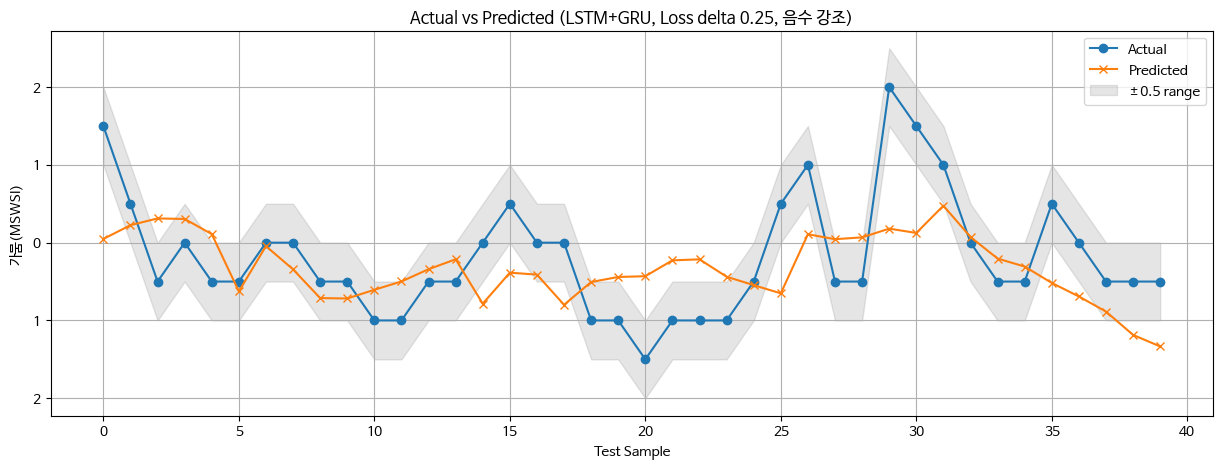

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target].values.astype(float)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ------------------------
# Train/Test 분리
# ------------------------
test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y[:-test_size], y[-test_size:]

# ------------------------
# 시퀀스 생성 함수
# ------------------------
def create_sequences(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, time_steps)

# ------------------------
# 시퀀스 oversampling + 노이즈 추가
# ------------------------
def oversample_sequences(X_seq, y_seq, factor_dict, noise_std=0.01):
    X_new, y_new = [], []
    for cls, factor in factor_dict.items():
        idx = np.where(y_seq == cls)[0]
        for i in idx:
            for _ in range(factor):
                # np.newaxis로 3D 변환 + 노이즈 추가
                X_aug = X_seq[i][np.newaxis, :, :] + np.random.normal(0, noise_std, X_seq[i].shape)[np.newaxis, :, :]
                X_new.append(X_aug)
                y_new.append(y_seq[i].reshape(1,1))
    if X_new:
        X_new = np.concatenate([X_seq] + X_new, axis=0)
        y_new = np.concatenate([y_seq.reshape(-1,1)] + y_new, axis=0).flatten()
    else:
        X_new, y_new = X_seq, y_seq
    return X_new, y_new

factor_dict = {-1.5:5, -1.0:2, -0.5:1, 0.0:1, 0.5:2, 1.0:3, 1.5:5, 2.0:5}
X_train_seq_bal, y_train_seq_bal = oversample_sequences(X_train_seq, y_train_seq, factor_dict)

print("Original train samples:", X_train_seq.shape[0])
print("After oversampling:", X_train_seq_bal.shape[0])

# ------------------------
# LSTM + GRU 모델 정의
# ------------------------
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# ------------------------
# Loss + sample_weight 조정
# ------------------------
# Huber Loss delta 축소 → 작은 오차 민감
model.compile(
    optimizer='adam',
    loss=Huber(delta=0.25),  # 기존 0.5 → 0.25
    metrics=['mae']
)

# 음수 클래스 강조
class_weights_dict = {-1.5:5, -1.0:3, -0.5:2, 0.0:1, 0.5:1, 1.0:1, 1.5:1, 2.0:1}
sample_weights = np.array([class_weights_dict.get(y,1) for y in y_train_seq_bal])

# ------------------------
# 학습
# ------------------------
history = model.fit(
    X_train_seq_bal, y_train_seq_bal,
    validation_split=0.2,
    sample_weight=sample_weights,
    epochs=150,
    batch_size=8,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)],
    verbose=1
)

# ------------------------
# 평가
# ------------------------
y_pred_cont = model.predict(X_test_seq).flatten()

# 근접 ±0.5 계산
y_pred_round = np.round(y_pred_cont * 2)/2
y_test_round = np.round(y_test_seq * 2)/2
prox_acc = np.mean(np.abs(y_test_round - y_pred_round) <= 0.5)
print("근접 정확도 (±0.5 단계):", prox_acc)

# 클래스별 근접 정확도
for cls in np.unique(y_test_round):
    idx = y_test_round == cls
    cls_acc = np.mean(np.abs(y_pred_round[idx] - cls) <= 0.5)
    print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")

# ------------------------
# 시각화
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(y_test_seq, label='Actual', marker='o')
plt.plot(y_pred_cont, label='Predicted', marker='x')
plt.fill_between(range(len(y_test_seq)), y_test_seq-0.5, y_test_seq+0.5, color='gray', alpha=0.2, label='±0.5 range')
plt.xlabel('Test Sample')
plt.ylabel('가뭄(MSWSI)')
plt.title('Actual vs Predicted (LSTM+GRU, Loss delta 0.25, 음수 강조)')
plt.legend()
plt.grid(True)
plt.show()


극단값 클래스(-1.5, 1.5, 2.0)를 강조한 데이터 증강 + Loss 가중치 적용 LSTM

Original train samples: 562
After oversampling extremes: 1500
Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1930 - mae: 0.4534 - val_loss: 0.8959 - val_mae: 1.4941 - learning_rate: 0.0010
Epoch 2/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1251 - mae: 0.3578 - val_loss: 0.7408 - val_mae: 1.1955 - learning_rate: 0.0010
Epoch 3/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1130 - mae: 0.3433 - val_loss: 0.6991 - val_mae: 1.0943 - learning_rate: 0.0010
Epoch 4/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1093 - mae: 0.3381 - val_loss: 0.7279 - val_mae: 1.1575 - learning_rate: 0.0010
Epoch 5/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1011 - mae: 0.3237 - val_loss: 0.6642 - val_mae: 1.0293 - learning_rate: 0.0010
Epoch 6/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1015 - mae: 0.3185 - val_loss: 0.7126 - val_mae: 1.1194 - learning_rate: 0.0010
Epoch 7/150
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0896 - mae: 0.2937 - val_loss: 0.7167 - val_mae: 1.1272 - learning_rate: 0.0010
Epoc

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


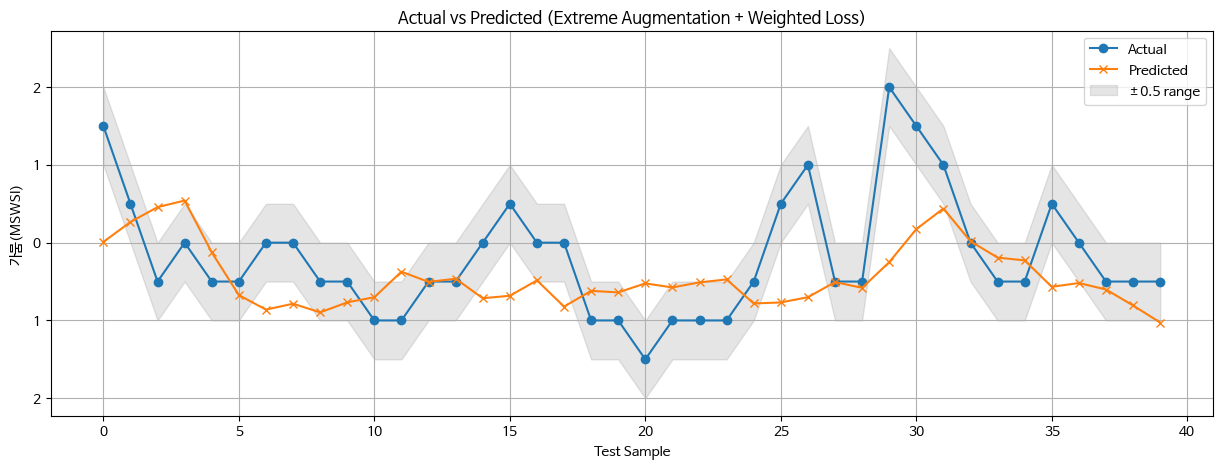

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target].values.astype(float)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ------------------------
# Train/Test 분리
# ------------------------
test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y[:-test_size], y[-test_size:]

# ------------------------
# 시퀀스 생성
# ------------------------
def create_sequences(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, time_steps)

# ------------------------
# 극단값 증강 함수
# ------------------------
def oversample_extremes(X_seq, y_seq, factor_dict, noise_std=0.01):
    X_new, y_new = [], []
    for cls, factor in factor_dict.items():
        idx = np.where(y_seq == cls)[0]
        for i in idx:
            for _ in range(factor):
                X_aug = X_seq[i][np.newaxis,:,:] + np.random.normal(0, noise_std, X_seq[i].shape)[np.newaxis,:,:]
                X_new.append(X_aug)
                y_new.append(y_seq[i].reshape(1,1))
    if X_new:
        X_new = np.concatenate([X_seq] + X_new, axis=0)
        y_new = np.concatenate([y_seq.reshape(-1,1)] + y_new, axis=0).flatten()
    else:
        X_new, y_new = X_seq, y_seq
    return X_new, y_new

# 극단값 복제 비율 조정
factor_dict = {-1.5:10, -1.0:3, -0.5:1, 0.0:1, 0.5:1, 1.0:2, 1.5:10, 2.0:10}
X_train_seq_bal, y_train_seq_bal = oversample_extremes(X_train_seq, y_train_seq, factor_dict)

print("Original train samples:", X_train_seq.shape[0])
print("After oversampling extremes:", X_train_seq_bal.shape[0])

# ------------------------
# LSTM + GRU 모델 정의
# ------------------------
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(time_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1, activation='linear')
])

# ------------------------
# Loss + sample_weight 조정
# ------------------------
model.compile(
    optimizer='adam',
    loss=Huber(delta=0.25),
    metrics=['mae']
)

# 극단값 강조 sample_weight
class_weights_dict = {-1.5:5, -1.0:3, -0.5:2, 0.0:1, 0.5:1, 1.0:1, 1.5:5, 2.0:5}
sample_weights = np.array([class_weights_dict.get(y,1) for y in y_train_seq_bal])

# ------------------------
# 학습
# ------------------------
history = model.fit(
    X_train_seq_bal, y_train_seq_bal,
    validation_split=0.2,
    sample_weight=sample_weights,
    epochs=150,
    batch_size=8,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)],
    verbose=1
)

# ------------------------
# 평가
# ------------------------
y_pred_cont = model.predict(X_test_seq).flatten()
y_pred_round = np.round(y_pred_cont * 2)/2
y_test_round = np.round(y_test_seq * 2)/2

prox_acc = np.mean(np.abs(y_test_round - y_pred_round) <= 0.5)
print("근접 정확도 (±0.5 단계):", prox_acc)

# 클래스별 근접 정확도
for cls in np.unique(y_test_round):
    idx = y_test_round == cls
    cls_acc = np.mean(np.abs(y_pred_round[idx] - cls) <= 0.5)
    print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")

# ------------------------
# 시각화
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(y_test_seq, label='Actual', marker='o')
plt.plot(y_pred_cont, label='Predicted', marker='x')
plt.fill_between(range(len(y_test_seq)), y_test_seq-0.5, y_test_seq+0.5, color='gray', alpha=0.2, label='±0.5 range')
plt.xlabel('Test Sample')
plt.ylabel('가뭄(MSWSI)')
plt.title('Actual vs Predicted (Extreme Augmentation + Weighted Loss)')
plt.legend()
plt.grid(True)
plt.show()


거의 모든 값 ±0.5 내에서 맞추는 강화 LSTM 모델

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.2744 - mae: 0.4333 - val_loss: 2.0214 - val_mae: 1.6544 - learning_rate: 0.0010
Epoch 2/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1818 - mae: 0.3850 - val_loss: 1.8896 - val_mae: 1.5302 - learning_rate: 0.0010
Epoch 3/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.1340 - mae: 0.3255 - val_loss: 1.8723 - val_mae: 1.5193 - learning_rate: 0.0010
Epoch 4/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1410 - mae: 0.3031 - val_loss: 1.6498 - val_mae: 1.3048 - learning_rate: 0.0010
Epoch 5/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1306 - mae: 0.2896 - val_loss: 1.3486 - val_mae: 1.0520 - learning_rate: 0.0010
Epoch 6/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.1362 - mae: 0.2639 - val_loss: 1.2769 - val_mae: 1.0206 - learning_rate: 0.0010
Epoch 7/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1299 - mae: 0.2583 - val_loss: 1.3395 - val_mae: 1.0310 - learning_rate

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


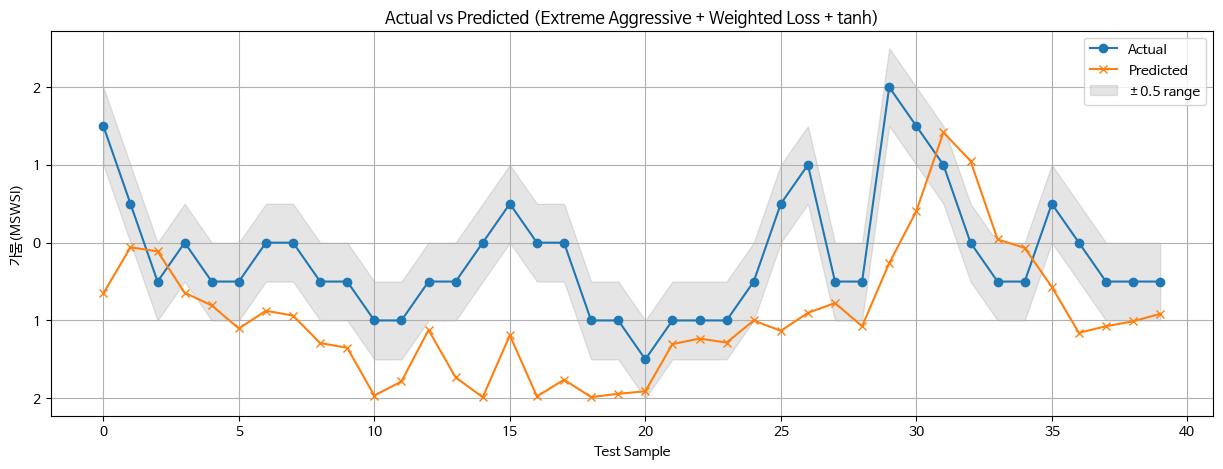

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target].values.astype(float)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# ------------------------
# Train/Test 분리
# ------------------------
test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y[:-test_size], y[-test_size:]

# ------------------------
# 시퀀스 생성
# ------------------------
def create_sequences(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, time_steps)

# ------------------------
# 극단값 공격적 증강
# ------------------------
def oversample_extremes(X_seq, y_seq, factor_dict, noise_std=0.01):
    X_new, y_new = [], []
    for cls, factor in factor_dict.items():
        idx = np.where(y_seq == cls)[0]
        for i in idx:
            for _ in range(factor):
                noise = np.random.normal(0, noise_std, X_seq[i].shape)
                X_aug = X_seq[i][np.newaxis,:,:] + noise[np.newaxis,:,:]
                X_new.append(X_aug)
                y_new.append(y_seq[i].reshape(1,1))
    if X_new:
        X_new = np.concatenate([X_seq] + X_new, axis=0)
        y_new = np.concatenate([y_seq.reshape(-1,1)] + y_new, axis=0).flatten()
    else:
        X_new, y_new = X_seq, y_seq
    return X_new, y_new

factor_dict = {-1.5:15, -1.0:5, -0.5:2, 0.0:1, 0.5:2, 1.0:3, 1.5:15, 2.0:15}
X_train_seq_bal, y_train_seq_bal = oversample_extremes(X_train_seq, y_train_seq, factor_dict)

# ------------------------
# 모델 정의
# ------------------------
def build_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        GRU(64),
        Dropout(0.2),
        Dense(1, activation='tanh')  # tanh로 -1~1 출력 제한 후 스케일링
    ])
    model.compile(optimizer='adam', loss=Huber(delta=0.25), metrics=['mae'])
    return model

model = build_model((time_steps, X_train_seq.shape[2]))

# ------------------------
# 클래스 가중치 -> sample_weight
# ------------------------
class_weights_dict = {-1.5:10, -1.0:5, -0.5:2, 0.0:1, 0.5:2, 1.0:3, 1.5:10, 2.0:10}
sample_weights = np.array([class_weights_dict.get(y,1) for y in y_train_seq_bal])

# ------------------------
# 학습
# ------------------------
history = model.fit(
    X_train_seq_bal, y_train_seq_bal,
    validation_split=0.2,
    sample_weight=sample_weights,
    epochs=150,
    batch_size=8,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)],
    verbose=1
)

# ------------------------
# 예측 및 post-processing
# ------------------------
y_pred_cont = model.predict(X_test_seq).flatten()
# tanh 출력 스케일 조정: -2 ~ 2
y_pred_cont_scaled = y_pred_cont * 2
y_pred_round = np.round(y_pred_cont_scaled * 2)/2
y_test_round = np.round(y_test_seq * 2)/2

# 음수 → 양수 튀는 경우 보정
y_pred_round[(y_test_round < 0) & (y_pred_round > 0)] = y_test_round[(y_test_round < 0) & (y_pred_round > 0)]

# ------------------------
# 평가
# ------------------------
prox_acc = np.mean(np.abs(y_test_round - y_pred_round) <= 0.5)
print("근접 정확도 (±0.5 단계):", prox_acc)

for cls in np.unique(y_test_round):
    idx = y_test_round == cls
    cls_acc = np.mean(np.abs(y_pred_round[idx] - cls) <= 0.5)
    print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")

# ------------------------
# 시각화
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(y_test_seq, label='Actual', marker='o')
plt.plot(y_pred_cont_scaled, label='Predicted', marker='x')
plt.fill_between(range(len(y_test_seq)), y_test_seq-0.5, y_test_seq+0.5, color='gray', alpha=0.2, label='±0.5 range')
plt.xlabel('Test Sample')
plt.ylabel('가뭄(MSWSI)')
plt.title('Actual vs Predicted (Extreme Aggressive + Weighted Loss + tanh)')
plt.legend()
plt.grid(True)
plt.show()


앙상블 실험

Epoch 1/150


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


206/206 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.6187 - mae: 0.3903 - val_loss: 8.0926 - val_mae: 1.4564 - learning_rate: 0.0010
Epoch 2/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.3685 - mae: 0.3219 - val_loss: 6.4311 - val_mae: 1.1667 - learning_rate: 0.0010
Epoch 3/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.3469 - mae: 0.3079 - val_loss: 5.5340 - val_mae: 1.1061 - learning_rate: 0.0010
Epoch 4/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.3490 - mae: 0.3029 - val_loss: 5.3192 - val_mae: 1.0553 - learning_rate: 0.0010
Epoch 5/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.3374 - mae: 0.2811 - val_loss: 4.6171 - val_mae: 0.9447 - learning_rate: 0.0010
Epoch 6/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.2464 - mae: 0.2632 - val_loss: 5.0150 - val_mae: 1.0181 - learning_rate: 0.0010
Epoch 7/150
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2713 - mae: 0.2782 - val_loss: 4.6276 - val_mae: 0.9519 - learning_rate: 0.0010
Epo

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


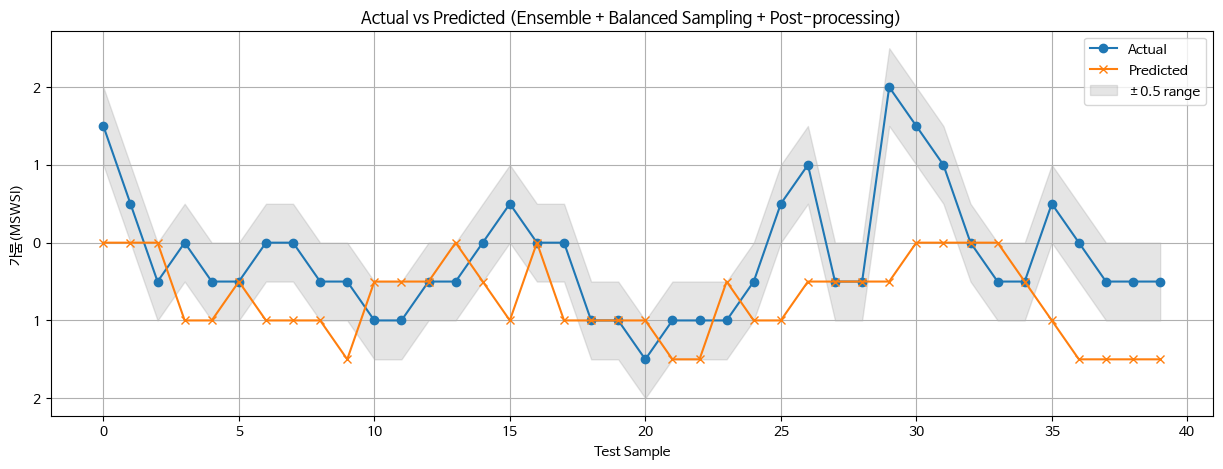

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# ------------------------
# 데이터 로드 및 전처리
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')
target = '가뭄(MSWSI)'
X = df.drop(['가뭄(MSWSI)','가뭄(SPI6)'], axis=1)
y = df[target].values.astype(float)

scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

test_size = 52
X_train_raw, X_test_raw = X_scaled[:-test_size], X_scaled[-test_size:]
y_train_raw, y_test_raw = y[:-test_size], y[-test_size:]

# ------------------------
# 시퀀스 생성
# ------------------------
def create_sequences(X_df, y_arr, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X_df) - time_steps):
        Xs.append(X_df.iloc[i:i+time_steps].values)
        ys.append(y_arr[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, time_steps)

# ------------------------
# 시퀀스 증강 함수
# ------------------------
def oversample_sequences(X_seq, y_seq, factor_dict, noise_std=0.01):
    X_new, y_new = [], []
    for cls, factor in factor_dict.items():
        idx = np.where(y_seq == cls)[0]
        for i in idx:
            for _ in range(factor):
                noise = np.random.normal(0, noise_std, X_seq[i].shape)
                X_aug = X_seq[i][np.newaxis,:,:] + noise[np.newaxis,:,:]
                X_new.append(X_aug)
                y_new.append(y_seq[i].reshape(1,1))
    if X_new:
        X_new = np.concatenate([X_seq] + X_new, axis=0)
        y_new = np.concatenate([y_seq.reshape(-1,1)] + y_new, axis=0).flatten()
    else:
        X_new, y_new = X_seq, y_seq
    return X_new, y_new

# ------------------------
# 모델 정의
# ------------------------
def build_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape),
        Dropout(0.2),
        GRU(64),
        Dropout(0.2),
        Dense(1, activation='tanh')  # tanh로 출력 제한
    ])
    model.compile(optimizer='adam', loss='huber', metrics=['mae'])
    return model

# ------------------------
# 앙상블 학습
# ------------------------
def train_ensemble(X_seq, y_seq):
    # 모델 A: 극단값 강조
    factor_extreme = {-1.5:15, -1.0:5, -0.5:2, 0.0:1, 0.5:2, 1.0:3, 1.5:15, 2.0:15}
    X_ext, y_ext = oversample_sequences(X_seq, y_seq, factor_extreme)
    sample_weights_ext = np.array([factor_extreme.get(y,1) for y in y_ext])
    model_ext = build_model((X_seq.shape[1], X_seq.shape[2]))
    model_ext.fit(X_ext, y_ext, sample_weight=sample_weights_ext, epochs=150, batch_size=8, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)], verbose=1)

    # 모델 B: 중간값 강조
    factor_mid = {-1.5:1, -1.0:2, -0.5:5, 0.0:10, 0.5:5, 1.0:2, 1.5:1, 2.0:1}
    X_mid, y_mid = oversample_sequences(X_seq, y_seq, factor_mid)
    sample_weights_mid = np.array([factor_mid.get(y,1) for y in y_mid])
    model_mid = build_model((X_seq.shape[1], X_seq.shape[2]))
    model_mid.fit(X_mid, y_mid, sample_weight=sample_weights_mid, epochs=150, batch_size=8, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)], verbose=1)

    return model_ext, model_mid

# ------------------------
# 예측 + Post-processing
# ------------------------
def ensemble_predict(models, X_seq, y_test_seq):
    preds = np.mean([m.predict(X_seq).flatten() for m in models], axis=0)
    preds_scaled = preds * 2  # tanh 출력 스케일링
    preds_rounded = np.round(preds_scaled * 2)/2

    # 음수→양수 튀는 경우 보정
    preds_rounded[(y_test_seq < 0) & (preds_rounded > 0)] = y_test_seq[(y_test_seq < 0) & (preds_rounded > 0)]
    return preds_rounded

# ------------------------
# 학습 실행
# ------------------------
model_ext, model_mid = train_ensemble(X_train_seq, y_train_seq)
y_pred_round = ensemble_predict([model_ext, model_mid], X_test_seq, y_test_seq)

# ------------------------
# 근접 정확도 평가
# ------------------------
y_test_round = np.round(y_test_seq * 2)/2
prox_acc = np.mean(np.abs(y_test_round - y_pred_round) <= 0.5)
print("근접 정확도 (±0.5 단계):", prox_acc)

for cls in np.unique(y_test_round):
    idx = y_test_round == cls
    cls_acc = np.mean(np.abs(y_pred_round[idx] - cls) <= 0.5)
    print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")

# ------------------------
# 시각화
# ------------------------
plt.figure(figsize=(15,5))
plt.plot(y_test_seq, label='Actual', marker='o')
plt.plot(y_pred_round, label='Predicted', marker='x')
plt.fill_between(range(len(y_test_seq)), y_test_seq-0.5, y_test_seq+0.5, color='gray', alpha=0.2, label='±0.5 range')
plt.xlabel('Test Sample')
plt.ylabel('가뭄(MSWSI)')
plt.title('Actual vs Predicted (Ensemble + Balanced Sampling + Post-processing)')
plt.legend()
plt.grid(True)
plt.show()


앙상블 개선

Epoch 1/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.5058 - mae: 0.3866 - val_loss: 3.7422 - val_mae: 1.1853 - learning_rate: 0.0010
Epoch 2/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3238 - mae: 0.2988 - val_loss: 3.2994 - val_mae: 1.0313 - learning_rate: 0.0010
Epoch 3/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.3186 - mae: 0.2901 - val_loss: 3.1667 - val_mae: 1.0089 - learning_rate: 0.0010
Epoch 4/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3034 - mae: 0.2781 - val_loss: 2.9753 - val_mae: 0.9392 - learning_rate: 0.0010
Epoch 5/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2595 - mae: 0.2527 - val_loss: 2.4806 - val_mae: 0.8172 - learning_rate: 0.0010
Epoch 6/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.2962 - mae: 0.2691 - val_loss: 2.8838 - val_mae: 0.8996 - learning_rate: 0.0010
Epoch 7/150
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2757 - mae: 0.2567 - val_loss: 2.4873 - val_mae: 0.7978 - learning_rate

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


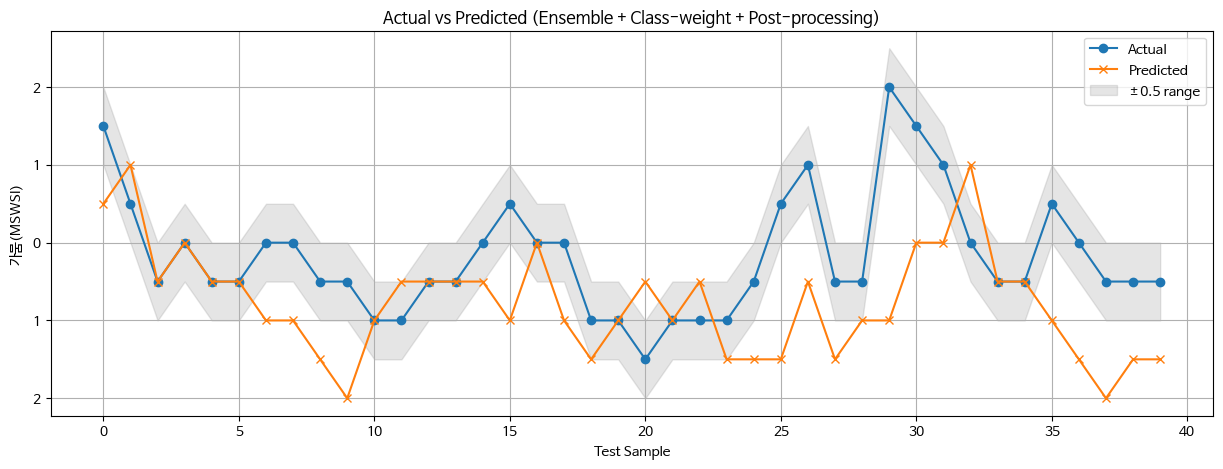

In [ ]:
# ------------------------
# 클래스별 증강 비율
# ------------------------
factor_extreme = {-1.5:15, -1.0:5, -0.5:2, 0.0:2, 0.5:3, 1.0:3, 1.5:10, 2.0:10}  # 극단값 모델
factor_mid = {-1.5:1, -1.0:2, -0.5:5, 0.0:10, 0.5:7, 1.0:3, 1.5:5, 2.0:5}       # 중간값 모델

# ------------------------
# 앙상블 학습
# ------------------------
X_ext, y_ext = oversample_sequences(X_train_seq, y_train_seq, factor_extreme)
sample_weights_ext = np.array([factor_extreme.get(y,1) for y in y_ext])
model_ext = build_model((X_train_seq.shape[1], X_train_seq.shape[2]))
model_ext.fit(X_ext, y_ext, sample_weight=sample_weights_ext, epochs=150, batch_size=8,
              validation_split=0.2,
              callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)], verbose=1)

X_mid, y_mid = oversample_sequences(X_train_seq, y_train_seq, factor_mid)
sample_weights_mid = np.array([factor_mid.get(y,1) for y in y_mid])
model_mid = build_model((X_train_seq.shape[1], X_train_seq.shape[2]))
model_mid.fit(X_mid, y_mid, sample_weight=sample_weights_mid, epochs=150, batch_size=8,
              validation_split=0.2,
              callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                         ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)], verbose=1)

# ------------------------
# 앙상블 예측 + Post-processing
# ------------------------
y_pred_final = ensemble_predict([model_ext, model_mid], X_test_seq, y_test_seq)

# ------------------------
# 최종 평가 함수 통합
# ------------------------
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(y_true, y_pred):
    # RMSE, MAE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    # ±0.5 근접 정확도
    prox_acc = np.mean(np.abs(y_true - y_pred) <= 0.5)
    print(f"근접 정확도 (±0.5 단계): {prox_acc:.3f}")

    # 클래스별 근접 정확도
    for cls in np.unique(y_true):
        idx = y_true == cls
        cls_acc = np.mean(np.abs(y_pred[idx] - cls) <= 0.5)
        print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")

    # 시각화
    plt.figure(figsize=(15,5))
    plt.plot(y_true, label='Actual', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.fill_between(range(len(y_true)), y_true-0.5, y_true+0.5, color='gray', alpha=0.2, label='±0.5 range')
    plt.xlabel('Test Sample')
    plt.ylabel('가뭄(MSWSI)')
    plt.title('Actual vs Predicted (Ensemble + Class-weight + Post-processing)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------
# 평가 실행
# ------------------------
evaluate_model(y_test_seq, y_pred_final)


결과적으로 제일 성능이 좋은 모델

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3978 - val_loss: 0.4313 - learning_rate: 0.0010
Epoch 2/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3117 - val_loss: 0.3659 - learning_rate: 0.0010
Epoch 3/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2307 - val_loss: 0.3396 - learning_rate: 0.0010
Epoch 4/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2162 - val_loss: 0.3364 - learning_rate: 0.0010
Epoch 5/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1824 - val_loss: 0.3449 - learning_rate: 0.0010
Epoch 6/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2171 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 7/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1772 - val_loss: 0.3889 - learning_rate: 0.0010
Epoch 8/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1806 - val_loss: 0.4035 - learning_rate: 0.0010
Epoch 9/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1794 - val_loss: 0.4167 - learning_rate: 0.0010
Epoch 10/150
58/58 

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


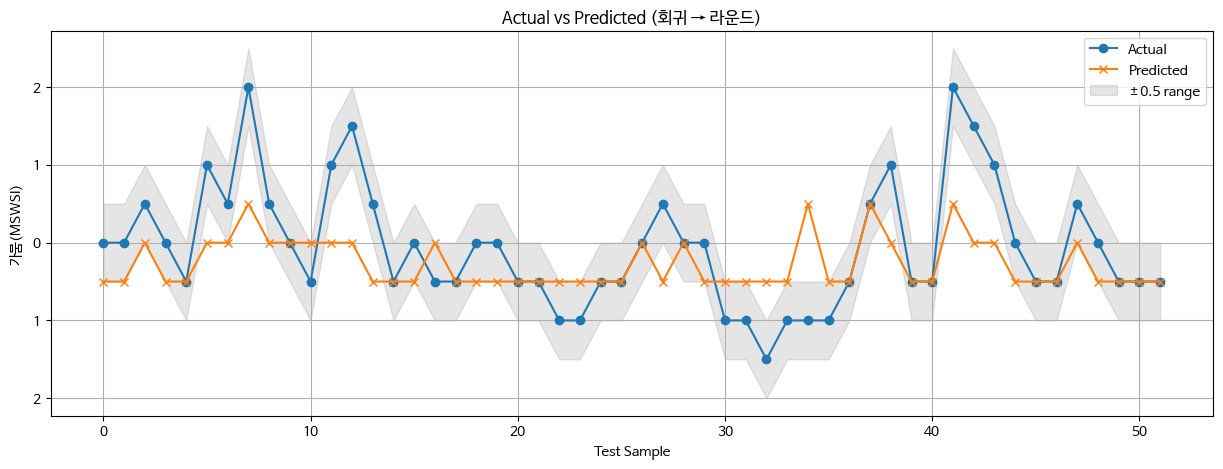

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ------------------------
# 데이터 불러오기
# ------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')
target = ['가뭄(MSWSI)', '가뭄(SPI6)']

X = df.drop(target, axis=1)
y = df[target]

test_size = 52  # 1년치 테스트 (주간 데이터 기준)
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# ------------------------
# 스케일링
# ------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame으로 변환 (인덱스와 컬럼 유지)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# ------------------------
# LSTM 입력 형태 변환 (샘플, 시퀀스 길이, feature)
# ------------------------
# 여기서는 시퀀스 길이를 1로 사용
X_train_seq = X_train_scaled.values.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_seq = X_test_scaled.values.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
y_train_seq = y_train['가뭄(MSWSI)'].values
y_test_seq = y_test['가뭄(MSWSI)'].values

# ------------------------
# LSTM 모델 정의
# ------------------------
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # 회귀 출력
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model((X_train_seq.shape[1], X_train_seq.shape[2]))

# ------------------------
# 학습
# ------------------------
model.fit(
    X_train_seq, y_train_seq,
    epochs=150, batch_size=8,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)
    ],
    verbose=1
)

# ------------------------
# 예측 (회귀 후 라운드)
# ------------------------
y_pred = model.predict(X_test_seq).flatten()
y_pred_rounded = np.round(y_pred * 2) / 2  # 0.5 단위로 라운딩

# ------------------------
# 성능 평가
# ------------------------
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    prox_acc = np.mean(np.abs(y_true - y_pred) <= 0.5)
    print(f"근접 정확도 (±0.5 단계): {prox_acc:.3f}")

    for cls in np.unique(y_true):
        idx = y_true == cls
        cls_acc = np.mean(np.abs(y_pred[idx] - cls) <= 0.5)
        print(f"Class {cls}: 근접 정확도 ±0.5 = {cls_acc:.2f}")

    plt.figure(figsize=(15,5))
    plt.plot(y_true, label='Actual', marker='o')
    plt.plot(y_pred, label='Predicted', marker='x')
    plt.fill_between(range(len(y_true)), y_true-0.5, y_true+0.5, color='gray', alpha=0.2, label='±0.5 range')
    plt.xlabel('Test Sample')
    plt.ylabel('가뭄(MSWSI)')
    plt.title('Actual vs Predicted (회귀 → 라운드)')
    plt.legend()
    plt.grid(True)
    plt.show()

# ------------------------
# 평가 실행
# ------------------------
evaluate_model(y_test_seq, y_pred_rounded)


# 일반모델

1차

훈련 데이터: (560, 14, 6) (560,)
테스트 데이터: (38, 14, 6) (38,)
클래스 가중치: {np.int64(0): np.float64(23.333333333333332), np.int64(1): np.float64(0.5223880597014925), np.int64(2): np.float64(0.3977272727272727), np.int64(3): np.float64(0.39325842696629215), np.int64(4): np.float64(1.5909090909090908), np.int64(5): np.float64(3.888888888888889), np.int64(6): np.float64(14.0), np.int64(7): np.float64(35.0)}
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.1773 - loss: 1.8369 - val_accuracy: 0.1053 - val_loss: 2.0331
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1978 - loss: 2.1155 - val_accuracy: 0.0526 - val_loss: 2.0179
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2158 - loss: 1.6988 - val_accuracy: 0.0526 - val_loss: 2.0191
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2010 - loss: 2.0648 - val_accuracy: 0.0526 - val_loss: 2.0451
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1466 - loss: 1.5452 - val_accuracy: 0.1053 - val_loss: 2.0477
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1985 - loss: 1.5923 - val_accuracy: 0.1316 - val_loss: 2.0733
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2389 - loss: 1.3438 - val_accuracy: 0.1053 - val_loss: 2.0841
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2270 - loss: 1.1852 - val_accuracy: 0.1842 - val_loss: 2.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/IPython/c

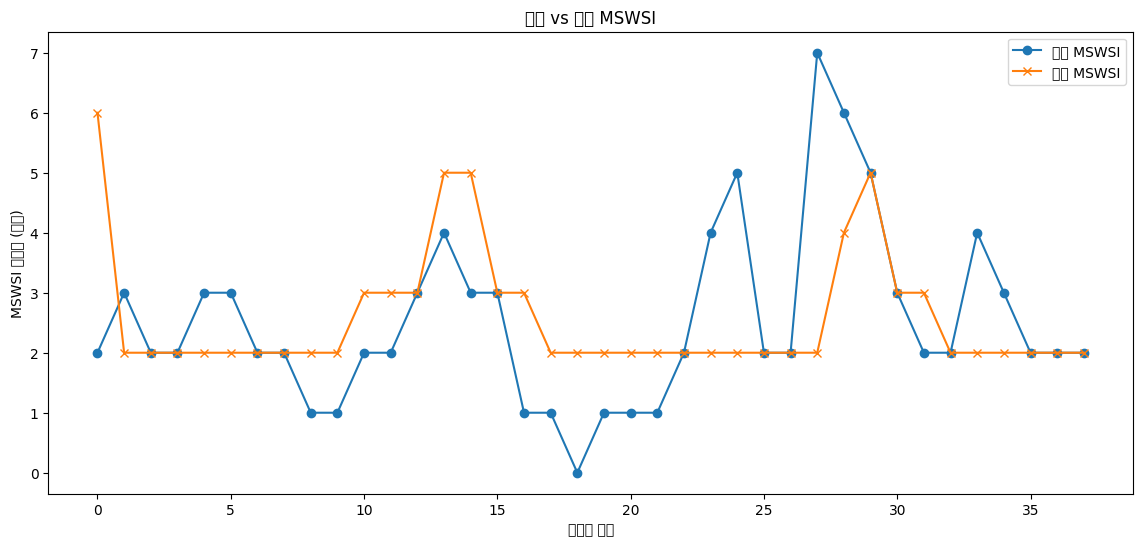

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


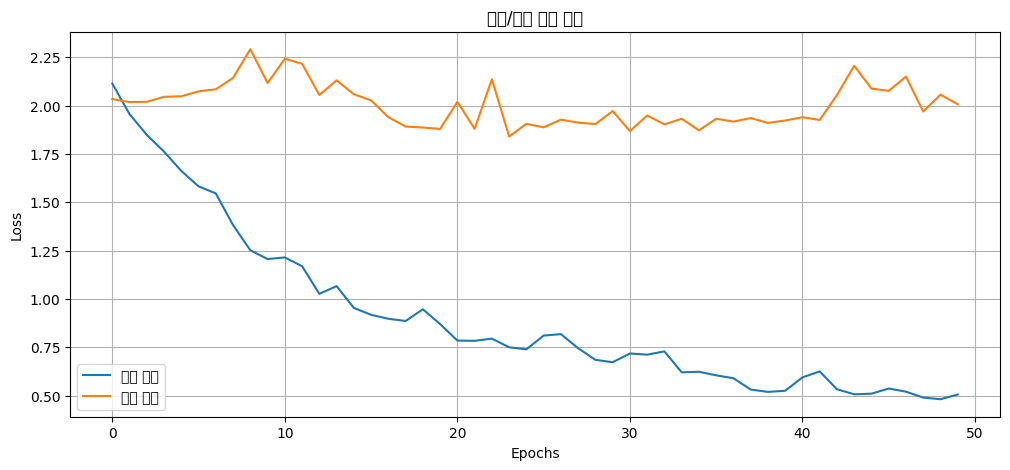

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


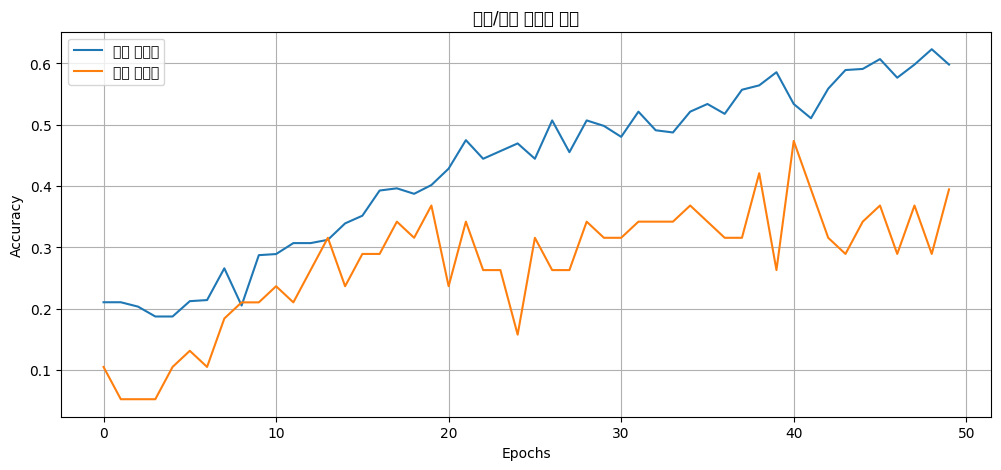

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ---------------------------
# 데이터 로드 & 분할
# ---------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

# 타겟: MSWSI 범주형
target = ['가뭄(MSWSI)']
X = df.drop(target, axis=1)
y = df[target]

# LabelEncoder로 클래스 숫자로 변환
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

# train/test 분리 (최근 52개를 test)
test_size = 52
X_train, X_test = X[:-test_size], X[-test_size:]
y_train_enc, y_test_enc = y_enc[:-test_size], y_enc[-test_size:]

# ---------------------------
# 스케일링
# ---------------------------
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust  = scaler_robust.transform(X_test)

X_train_robust = pd.DataFrame(X_train_robust, columns=X_train.columns, index=X_train.index)
X_test_robust  = pd.DataFrame(X_test_robust,  columns=X_test.columns,  index=X_test.index)

# ---------------------------
# 시퀀스 생성 (time_steps 증가)
# ---------------------------
def create_sequences_class(X, y, time_steps=14):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 14  # 최근 14일 데이터 사용
X_train_seq, y_train_seq = create_sequences_class(X_train_robust, y_train_enc, time_steps)
X_test_seq, y_test_seq   = create_sequences_class(X_test_robust, y_test_enc, time_steps)

print("훈련 데이터:", X_train_seq.shape, y_train_seq.shape)
print("테스트 데이터:", X_test_seq.shape, y_test_seq.shape)

# ---------------------------
# 클래스 불균형 가중치 계산
# ---------------------------
classes = np.unique(y_train_seq)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weight_dict = dict(zip(classes, class_weights))
print("클래스 가중치:", class_weight_dict)

# ---------------------------
# LSTM 모델 정의
# ---------------------------
n_classes = len(le.classes_)

model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ---------------------------
# 학습
# ---------------------------
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=16,
    class_weight=class_weight_dict,
    verbose=1
)

# ---------------------------
# 예측 & 분류 성능 평가
# ---------------------------
y_pred_prob = model.predict(X_test_seq)
y_pred_class = np.argmax(y_pred_prob, axis=1)

print("\n=== 상세 분류 리포트 ===")
print(classification_report(
    y_test_seq,
    y_pred_class,
    target_names=le.classes_.astype(str)  # 라벨 이름을 원래 클래스명으로 표시
))

# ---------------------------
# 시각화 (실제 vs 예측)
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_seq, label="실제 MSWSI", marker='o')
plt.plot(y_pred_class, label="예측 MSWSI", marker='x')
plt.title("실제 vs 예측 MSWSI")
plt.xlabel("테스트 기간")
plt.ylabel("MSWSI 클래스 (숫자)")
plt.legend()
plt.show()

# ---------------------------
# 학습 손실 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title("훈련/검증 손실 추이")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 정확도 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title("훈련/검증 정확도 추이")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()



2차

훈련 데이터: (560, 14, 6) (560,)
테스트 데이터: (38, 14, 6) (38,)
클래스 가중치: {np.int64(0): np.float64(23.333333333333332), np.int64(1): np.float64(0.5223880597014925), np.int64(2): np.float64(0.3977272727272727), np.int64(3): np.float64(0.39325842696629215), np.int64(4): np.float64(1.5909090909090908), np.int64(5): np.float64(3.888888888888889), np.int64(6): np.float64(14.0), np.int64(7): np.float64(35.0)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.2205 - loss: 2.1073

18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 417ms/step - accuracy: 0.2201 - loss: 2.1106 - val_accuracy: 0.1842 - val_loss: 2.0109 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.2248 - loss: 1.6414 - val_accuracy: 0.0789 - val_loss: 2.1220 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.1418 - loss: 2.0931 - val_accuracy: 0.1053 - val_loss: 2.3145 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 300ms/step - accuracy: 0.1430 - loss: 1.6914 - val_accuracy: 0.1579 - val_loss: 2.0158 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 301ms/step - accuracy: 0.2605 - loss: 1.4986 - val_accuracy: 0.1579 - val_loss: 2.3884 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.1855 - loss: 1.3889
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - accuracy: 0.1877 - loss: 1.3887 - val_a

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


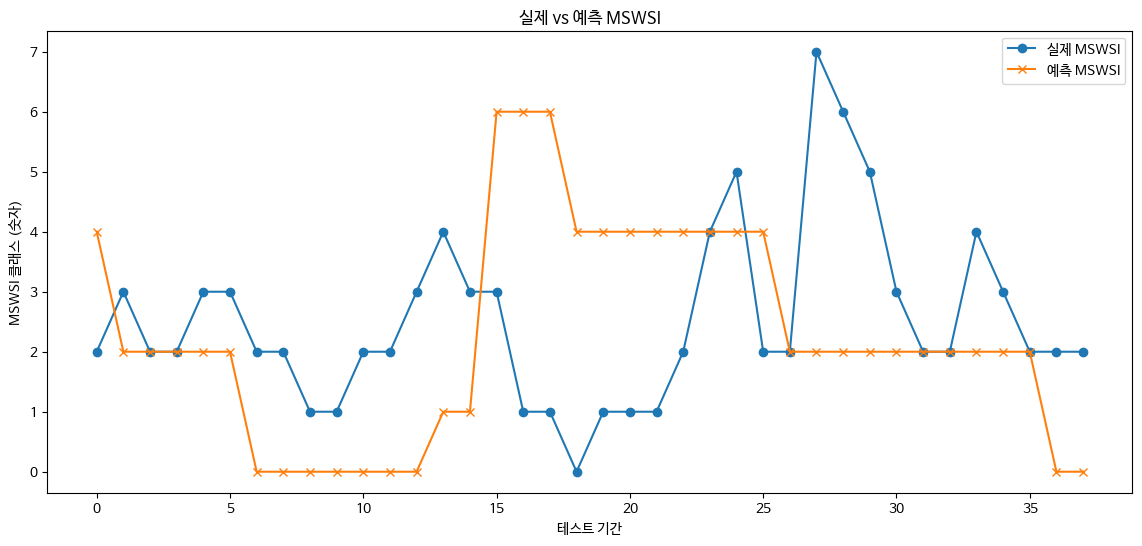

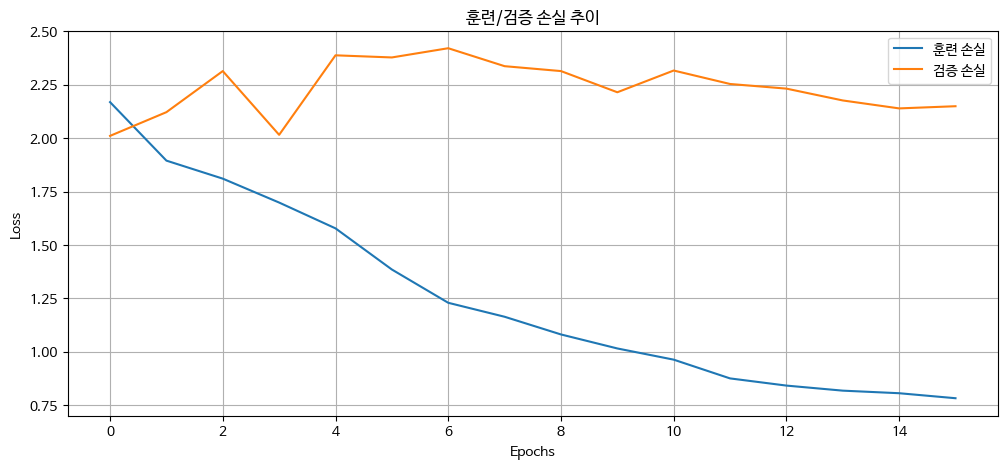

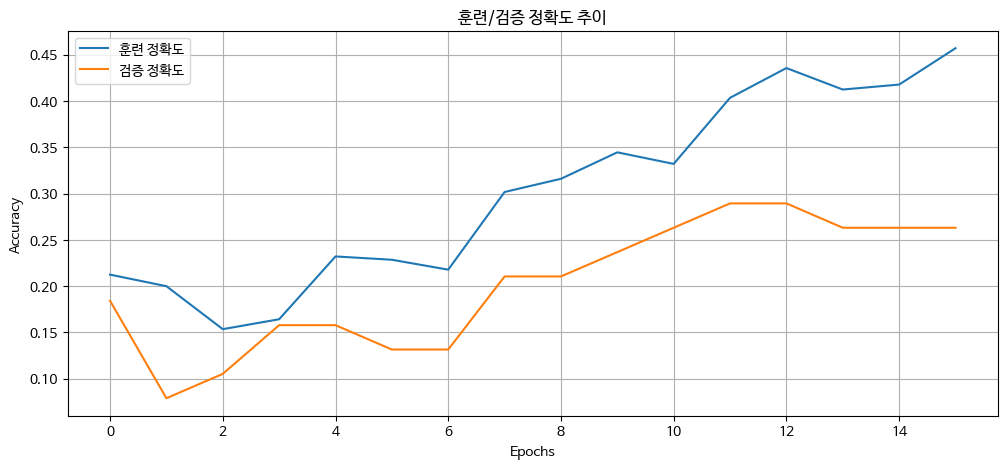

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ---------------------------
# 데이터 로드 & 분할
# ---------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

target = ['가뭄(MSWSI)']
X = df.drop(target, axis=1)
y = df[target]

le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

test_size = 52
X_train, X_test = X[:-test_size], X[-test_size:]
y_train_enc, y_test_enc = y_enc[:-test_size], y_enc[-test_size:]

# ---------------------------
# 스케일링
# ---------------------------
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust  = scaler_robust.transform(X_test)

X_train_robust = pd.DataFrame(X_train_robust, columns=X_train.columns, index=X_train.index)
X_test_robust  = pd.DataFrame(X_test_robust,  columns=X_test.columns,  index=X_test.index)

# ---------------------------
# 시퀀스 생성
# ---------------------------
def create_sequences_class(X, y, time_steps=14):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 14
X_train_seq, y_train_seq = create_sequences_class(X_train_robust, y_train_enc, time_steps)
X_test_seq, y_test_seq   = create_sequences_class(X_test_robust, y_test_enc, time_steps)

print("훈련 데이터:", X_train_seq.shape, y_train_seq.shape)
print("테스트 데이터:", X_test_seq.shape, y_test_seq.shape)

# ---------------------------
# 클래스 불균형 가중치
# ---------------------------
classes = np.unique(y_train_seq)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weight_dict = dict(zip(classes, class_weights))
print("클래스 가중치:", class_weight_dict)

# ---------------------------
# LSTM 모델 정의 (Bidirectional 2층)
# ---------------------------
n_classes = len(le.classes_)

model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, activation='tanh'), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(256, activation='tanh')),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ---------------------------
# 콜백 정의
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# ---------------------------
# 학습
# ---------------------------
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# ---------------------------
# 예측 & 분류 성능 평가
# ---------------------------
y_pred_prob = model.predict(X_test_seq)
y_pred_class = np.argmax(y_pred_prob, axis=1)

print("\n=== 상세 분류 리포트 ===")
print(classification_report(
    y_test_seq,
    y_pred_class,
    target_names=le.classes_.astype(str)  # 라벨 이름을 원래 클래스명으로 표시
))

# ---------------------------
# 시각화
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_seq, label="실제 MSWSI", marker='o')
plt.plot(y_pred_class, label="예측 MSWSI", marker='x')
plt.title("실제 vs 예측 MSWSI")
plt.xlabel("테스트 기간")
plt.ylabel("MSWSI 클래스 (숫자)")
plt.legend()
plt.show()

# ---------------------------
# 학습 손실 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title("훈련/검증 손실 추이")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 정확도 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title("훈련/검증 정확도 추이")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# 종속변수 클래스 3(LSTM 아님, 잘못생각해서 dense 모델로 돌린것)

1차

클래스 가중치: {np.int64(0): np.float64(0.6035751840168244), np.int64(1): np.float64(1.0342342342342343), np.int64(2): np.float64(2.6574074074074074)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3239 - loss: 1.2161 - val_accuracy: 0.4038 - val_loss: 1.0799
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3907 - loss: 1.0689 - val_accuracy: 0.5000 - val_loss: 1.0532
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4618 - loss: 1.0825 - val_accuracy: 0.5385 - val_loss: 1.0251
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5799 - loss: 1.0004 - val_accuracy: 0.5769 - val_loss: 1.0042
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5998 - loss: 0.9596 - val_accuracy: 0.5962 - val_loss: 0.9939
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5883 - loss: 0.9512 - val_accuracy: 0.6154 - val_loss: 0.9669
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6026 - loss: 0.9244 - val_accuracy: 0.6346 - val_loss: 0.9337
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6458 - loss: 0.9156 - val_accuracy: 0.6154 - val_lo

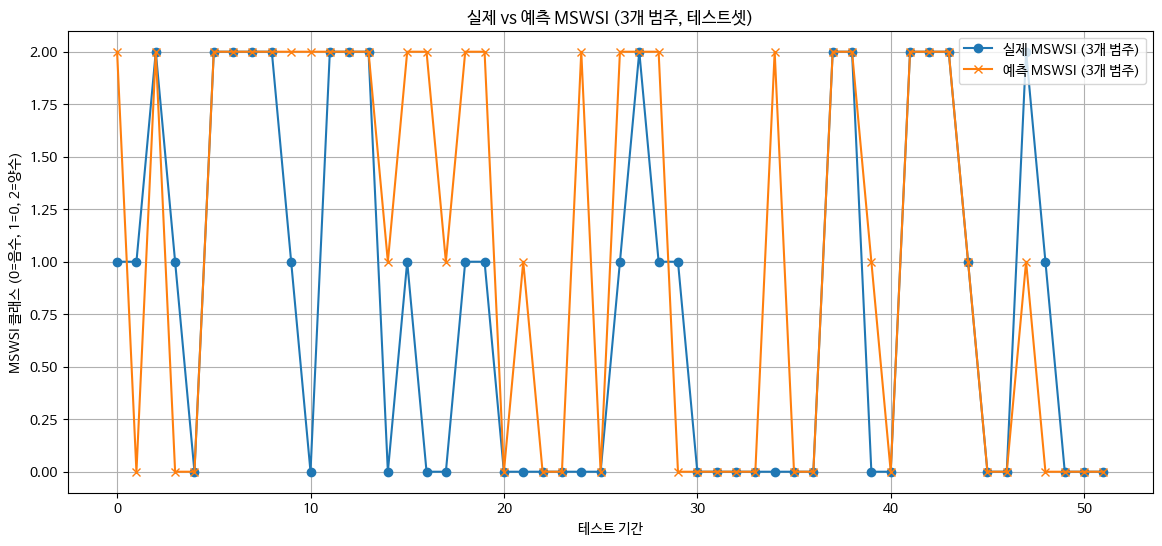

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# ---------------------------
# 데이터 로드
# ---------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

# ---------------------------
# MSWSI 9개 -> 3개 축소
# ---------------------------
def mswsi_to_3class(x):
    if x < 0:
        return 0  # 음수
    elif x == 0:
        return 1  # 0
    else:
        return 2  # 양수

df['가뭄_3class'] = df['가뭄(MSWSI)'].apply(mswsi_to_3class)

# ---------------------------
# 독립/종속 변수
# ---------------------------
target = '가뭄_3class'
X = df.drop(['가뭄(MSWSI)', target], axis=1)
y = df[target]

# ---------------------------
# 데이터 분할
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=52, shuffle=False
)

# ---------------------------
# 스케일링
# ---------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------
# 클래스 가중치
# ---------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("클래스 가중치:", class_weight_dict)

# ---------------------------
# LSTM 없이 Dense 모델 정의
# ---------------------------
n_classes = len(classes)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ---------------------------
# 학습
# ---------------------------
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=16,
    class_weight=class_weight_dict,
    verbose=1
)

# ---------------------------
# 예측 & 성능 평가
# ---------------------------
y_pred_prob = model.predict(X_test_scaled)
y_pred_class = np.argmax(y_pred_prob, axis=1)

acc  = accuracy_score(y_test, y_pred_class)
prec = precision_score(y_test, y_pred_class, average='macro')
rec  = recall_score(y_test, y_pred_class, average='macro')
f1   = f1_score(y_test, y_pred_class, average='macro')

print("\n분류 성능 평가 (테스트셋)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="실제 MSWSI (3개 범주)", marker='o')
plt.plot(y_pred_class, label="예측 MSWSI (3개 범주)", marker='x')
plt.title("실제 vs 예측 MSWSI")
plt.xlabel("테스트 기간")
plt.ylabel("MSWSI 클래스 (0=음수, 1=0, 2=양수)")
plt.legend()
plt.grid(True)
plt.show()


2차

클래스 가중치: {np.int64(0): np.float64(0.6035751840168244), np.int64(1): np.float64(1.0342342342342343), np.int64(2): np.float64(2.6574074074074074)}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3066 - loss: 1.1359 - val_accuracy: 0.5192 - val_loss: 1.0184
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5432 - loss: 0.9885 - val_accuracy: 0.5962 - val_loss: 0.9960
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5908 - loss: 0.9413 - val_accuracy: 0.6731 - val_loss: 0.9412
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6018 - loss: 0.9680 - val_accuracy: 0.6538 - val_loss: 0.8915
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6185 - loss: 0.8554 - val_accuracy: 0.6538 - val_loss: 0.8701
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6265 - loss: 0.8336 - val_accuracy: 0.6346 - val_loss: 0.9043
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6306 - loss: 0.8468 - val_accuracy: 0.6538 - val_loss: 0.8584
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6308 - loss: 0.8419 - val_accuracy: 0.6923 - val_loss: 0.8

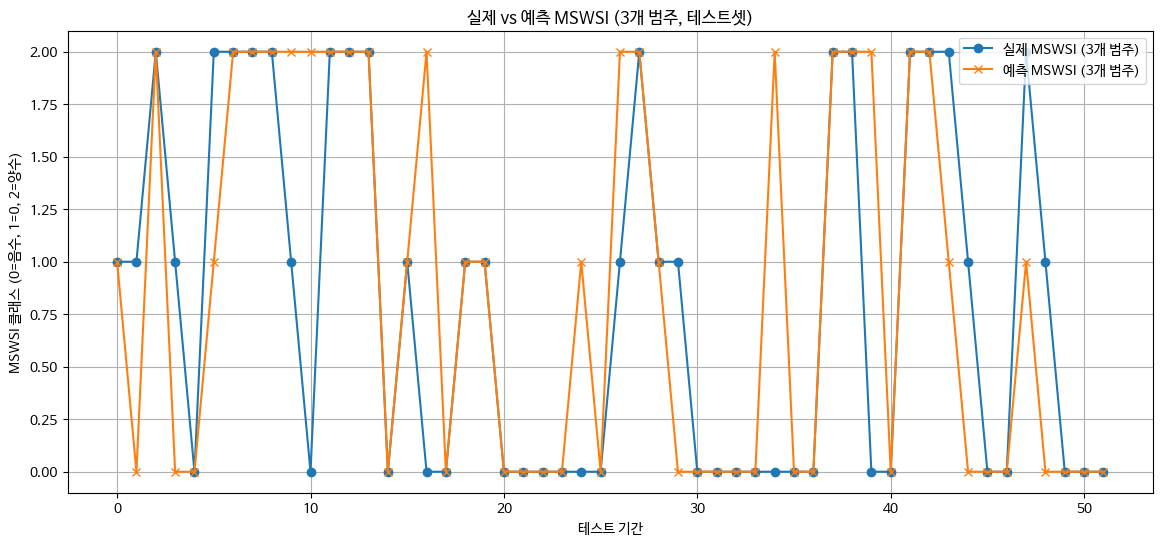

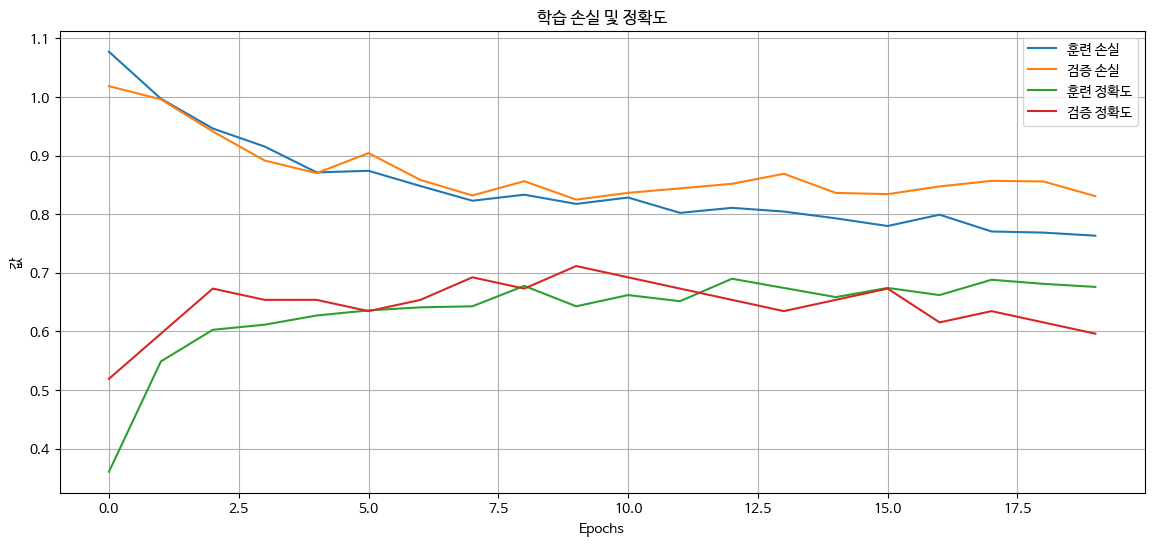

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ---------------------------
# 데이터 로드
# ---------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

# ---------------------------
# MSWSI 3개 범주로 축소
# ---------------------------
def mswsi_to_3class(x):
    if x < 0:
        return 0  # 음수
    elif x == 0:
        return 1  # 0
    else:
        return 2  # 양수

df['가뭄_3class'] = df['가뭄(MSWSI)'].apply(mswsi_to_3class)

# ---------------------------
# 독립/종속 변수
# ---------------------------
target = '가뭄_3class'
X = df.drop(['가뭄(MSWSI)', target], axis=1)
y = df[target]

# ---------------------------
# 데이터 분할
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=52, shuffle=False
)

# ---------------------------
# 스케일링
# ---------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------
# 클래스 가중치
# ---------------------------
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("클래스 가중치:", class_weight_dict)

# ---------------------------
# 모델 정의 (추천 하이퍼파라미터 적용)
# ---------------------------
n_classes = len(classes)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------------------
# 학습
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=8,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# 예측 & 성능 평가
# ---------------------------
y_pred_prob = model.predict(X_test_scaled)
y_pred_class = np.argmax(y_pred_prob, axis=1)

acc  = accuracy_score(y_test, y_pred_class)
prec = precision_score(y_test, y_pred_class, average='macro')
rec  = recall_score(y_test, y_pred_class, average='macro')
f1   = f1_score(y_test, y_pred_class, average='macro')

print("\n분류 성능 평가 (테스트셋)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# ---------------------------
# 실제 vs 예측 그래프
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="실제 MSWSI (3개 범주)", marker='o')
plt.plot(y_pred_class, label="예측 MSWSI (3개 범주)", marker='x')
plt.title("실제 vs 예측 MSWSI")
plt.xlabel("테스트 기간")
plt.ylabel("MSWSI 클래스 (0=음수, 1=0, 2=양수)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 손실/정확도 그래프
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title("학습 손실 및 정확도")
plt.xlabel("Epochs")
plt.ylabel("값")
plt.legend()
plt.grid(True)
plt.show()


# 클래스 3변수

1차

훈련 데이터: (560, 14, 6) (560,)
테스트 데이터: (38, 14, 6) (38,)
클래스 가중치: {np.int64(0): np.float64(0.5963791267305645), np.int64(1): np.float64(1.048689138576779), np.int64(2): np.float64(2.7053140096618358)}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.4247 - loss: 1.1134 - val_accuracy: 0.4737 - val_loss: 1.0872
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4204 - loss: 1.0311 - val_accuracy: 0.4737 - val_loss: 1.0498
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4411 - loss: 1.0544 - val_accuracy: 0.4474 - val_loss: 1.0246
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.4949 - loss: 0.9802 - val_accuracy: 0.4211 - val_loss: 1.0341
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5204 - loss: 0.9868 - val_accuracy: 0.4737 - val_loss: 0.9987
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5974 - loss: 0.9280 - val_accuracy: 0.6053 - val_loss: 0.9814
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6511 - loss: 0.8890 - val_accuracy: 0.6053 - val_loss: 0.9581
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6267 - loss: 0.8916 - val_accuracy: 0.5789 - val_l

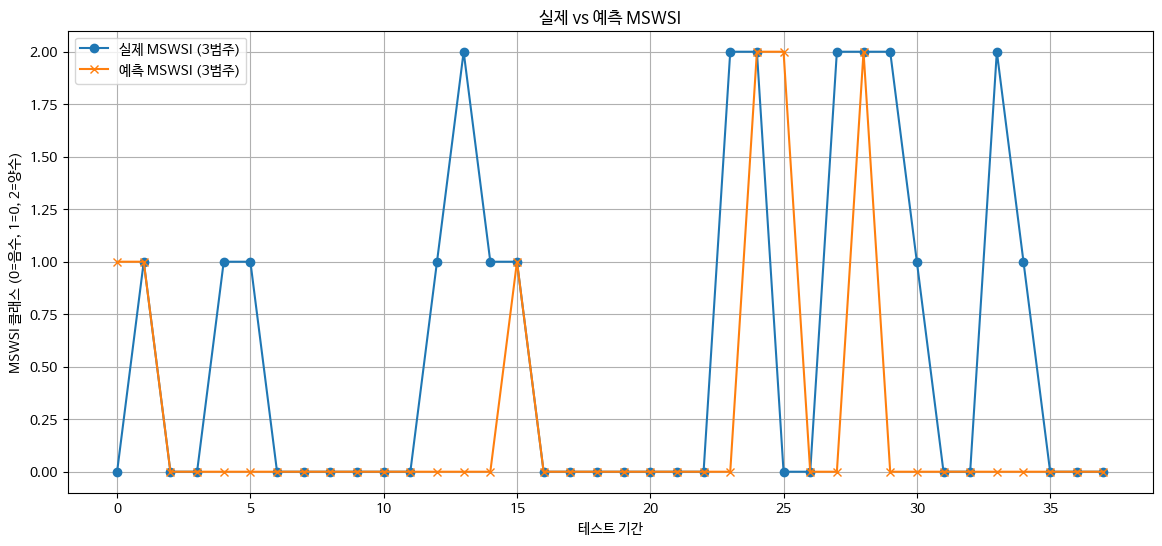

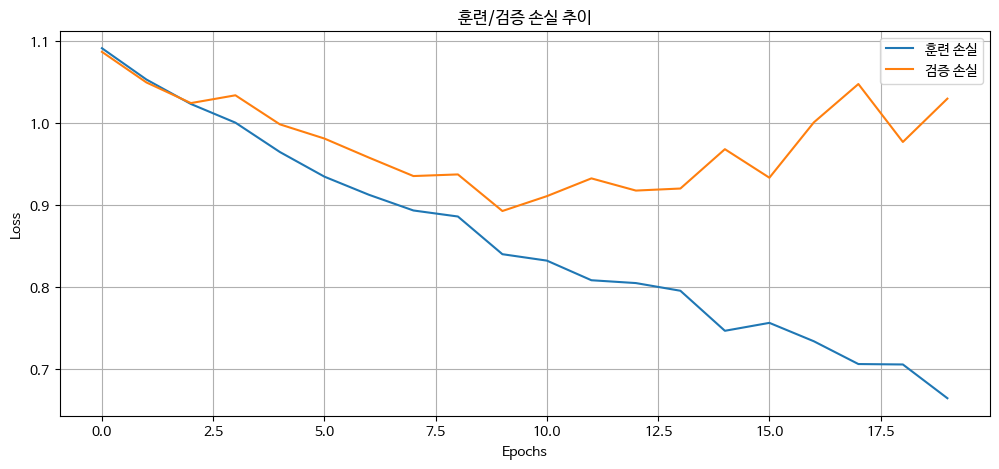

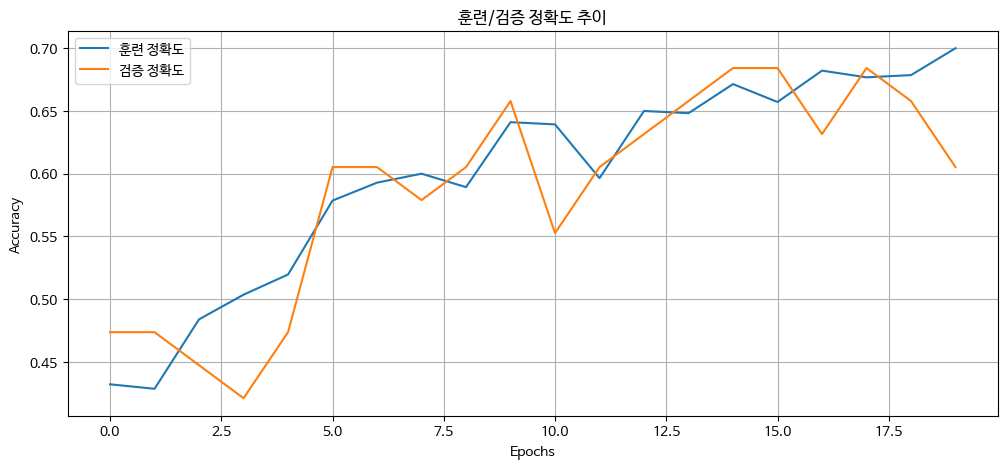

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# 데이터 로드 & 변환
# ---------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

# MSWSI → 3개 범주 (음수=0, 0=1, 양수=2)
def mswsi_to_3class(x):
    if x < 0:
        return 0
    elif x == 0:
        return 1
    else:
        return 2

df['가뭄_3class'] = df['가뭄(MSWSI)'].apply(mswsi_to_3class)

# ---------------------------
# 독립변수 / 종속변수
# ---------------------------
target = '가뭄_3class'
X = df.drop(['가뭄(MSWSI)', target], axis=1)
y = df[target].values

# ---------------------------
# Train/Test 분리
# ---------------------------
test_size = 52
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# ---------------------------
# 스케일링
# ---------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

# ---------------------------
# 시퀀스 생성 (time_steps 사용)
# ---------------------------
def create_sequences_class(X, y, time_steps=14):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 14
X_train_seq, y_train_seq = create_sequences_class(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq   = create_sequences_class(X_test_scaled, y_test, time_steps)

print("훈련 데이터:", X_train_seq.shape, y_train_seq.shape)
print("테스트 데이터:", X_test_seq.shape, y_test_seq.shape)

# ---------------------------
# 클래스 불균형 가중치
# ---------------------------
classes = np.unique(y_train_seq)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weight_dict = dict(zip(classes, class_weights))
print("클래스 가중치:", class_weight_dict)

# ---------------------------
# LSTM 모델 정의
# ---------------------------
n_classes = len(classes)

model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ---------------------------
# 학습
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=8,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# 예측 & 평가
# ---------------------------
y_pred_prob = model.predict(X_test_seq)
y_pred_class = np.argmax(y_pred_prob, axis=1)

acc  = accuracy_score(y_test_seq, y_pred_class)
prec = precision_score(y_test_seq, y_pred_class, average='macro')
rec  = recall_score(y_test_seq, y_pred_class, average='macro')
f1   = f1_score(y_test_seq, y_pred_class, average='macro')

print("\n분류 성능 평가 (테스트셋)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# ---------------------------
# 시각화: 실제 vs 예측
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_seq, label="실제 MSWSI (3범주)", marker='o')
plt.plot(y_pred_class, label="예측 MSWSI (3범주)", marker='x')
plt.title("실제 vs 예측 MSWSI")
plt.xlabel("테스트 기간")
plt.ylabel("MSWSI 클래스 (0=음수, 1=0, 2=양수)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 손실 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title("훈련/검증 손실 추이")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 정확도 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title("훈련/검증 정확도 추이")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()



2차

훈련 데이터: (564, 10, 6) (564,)
테스트 데이터: (42, 10, 6) (42,)
클래스 가중치: {np.int64(0): np.float64(0.6006389776357828), np.int64(1): np.float64(1.0444444444444445), np.int64(2): np.float64(2.647887323943662)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.3863 - loss: 1.0728 - val_accuracy: 0.3095 - val_loss: 1.1015
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3092 - loss: 1.1211 - val_accuracy: 0.3095 - val_loss: 1.1056
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3337 - loss: 1.1382 - val_accuracy: 0.3333 - val_loss: 1.1005
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3615 - loss: 0.9987 - val_accuracy: 0.3571 - val_loss: 1.0869
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3689 - loss: 1.0438 - val_accuracy: 0.4048 - val_loss: 1.0760
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4176 - loss: 1.0947 - val_accuracy: 0.3571 - val_loss: 1.0744
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4835 - loss: 0.9903 - val_accuracy: 0.4762 - val_loss: 1.0538
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4905 - loss: 1.0104 - val_accuracy: 0.452

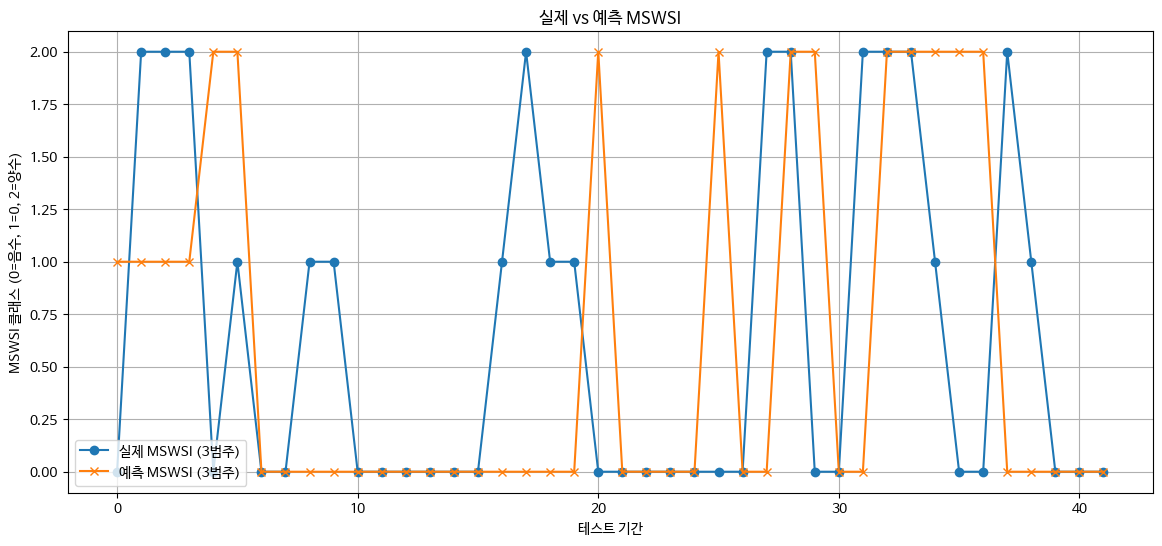

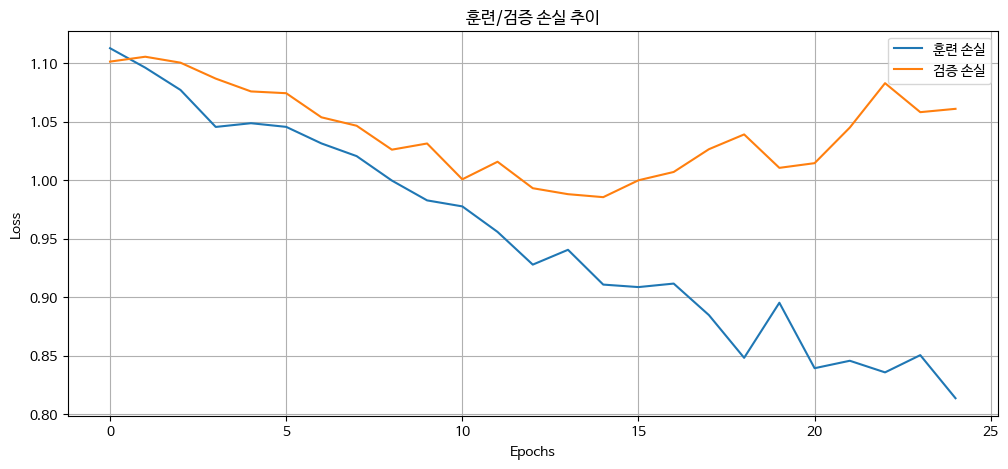

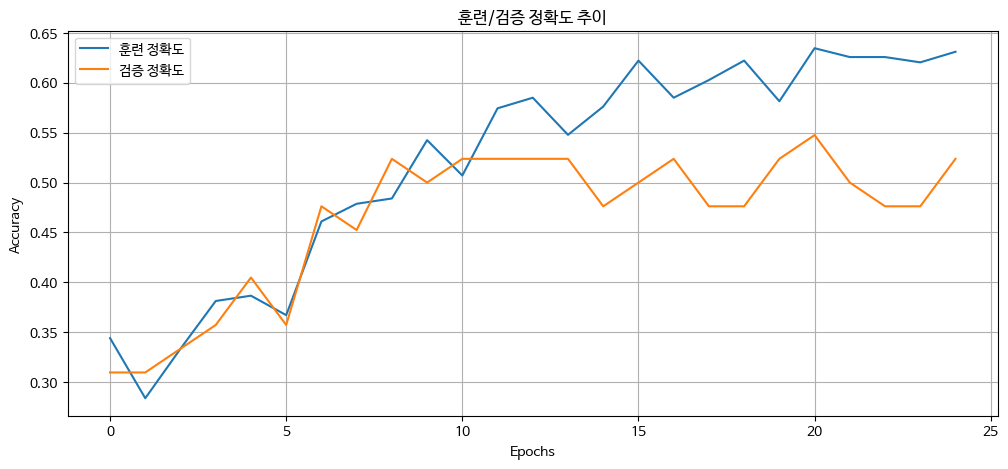

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# 데이터 로드 & 분할
# ---------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

# 타겟: MSWSI (3개 범주: 음수, 0, 양수)
target = ['가뭄(MSWSI)']
X = df.drop(target, axis=1)
y = df[target]

# 3개 범주로 변환
y = y.apply(lambda val: -1 if val.values[0] < 0 else (1 if val.values[0] > 0 else 0), axis=1)

# LabelEncoder (0=음수, 1=0, 2=양수)
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

# train/test 분리 (최근 52개를 test)
test_size = 52
X_train, X_test = X[:-test_size], X[-test_size:]
y_train_enc, y_test_enc = y_enc[:-test_size], y_enc[-test_size:]

# ---------------------------
# 스케일링
# ---------------------------
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust  = scaler_robust.transform(X_test)

X_train_robust = pd.DataFrame(X_train_robust, columns=X_train.columns, index=X_train.index)
X_test_robust  = pd.DataFrame(X_test_robust,  columns=X_test.columns,  index=X_test.index)

# ---------------------------
# 시퀀스 생성 (time_steps=10)
# ---------------------------
def create_sequences_class(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X_train_seq, y_train_seq = create_sequences_class(X_train_robust, y_train_enc, time_steps)
X_test_seq, y_test_seq   = create_sequences_class(X_test_robust, y_test_enc, time_steps)

print("훈련 데이터:", X_train_seq.shape, y_train_seq.shape)
print("테스트 데이터:", X_test_seq.shape, y_test_seq.shape)

# ---------------------------
# 클래스 불균형 가중치 계산
# ---------------------------
classes = np.unique(y_train_seq)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weight_dict = dict(zip(classes, class_weights))
print("클래스 가중치:", class_weight_dict)

# ---------------------------
# LSTM 모델 정의
# ---------------------------
n_classes = len(le.classes_)

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ---------------------------
# 학습 (EarlyStopping 적용)
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=8,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# 예측 & 성능 평가
# ---------------------------
y_pred_prob = model.predict(X_test_seq)
y_pred_class = np.argmax(y_pred_prob, axis=1)

acc  = accuracy_score(y_test_seq, y_pred_class)
prec = precision_score(y_test_seq, y_pred_class, average='macro')
rec  = recall_score(y_test_seq, y_pred_class, average='macro')
f1   = f1_score(y_test_seq, y_pred_class, average='macro')

print("\n분류 성능 평가 (테스트셋)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# ---------------------------
# 시각화 (실제 vs 예측)
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_seq, label="실제 MSWSI (3범주)", marker='o')
plt.plot(y_pred_class, label="예측 MSWSI (3범주)", marker='x')
plt.title("실제 vs 예측 MSWSI")
plt.xlabel("테스트 기간")
plt.ylabel("MSWSI 클래스 (0=음수, 1=0, 2=양수)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 손실 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title("훈련/검증 손실 추이")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 정확도 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title("훈련/검증 정확도 추이")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# 클래스2

1차

클래스 가중치: {np.int64(0): np.float64(1.1336032388663968), np.int64(1): np.float64(0.8945686900958466)}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5803 - loss: 0.6787 - val_accuracy: 0.5000 - val_loss: 0.6907
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6390 - loss: 0.6512 - val_accuracy: 0.6316 - val_loss: 0.6631
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6431 - loss: 0.6222 - val_accuracy: 0.6579 - val_loss: 0.6679
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7244 - loss: 0.5608 - val_accuracy: 0.5789 - val_loss: 0.6574
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7232 - loss: 0.5470 - val_accuracy: 0.6316 - val_loss: 0.6843
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7399 - loss: 0.5394 - val_accuracy: 0.6579 - val_loss: 0.7179
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7290 - loss: 0.5281 - val_accuracy: 0.6053 - val_loss: 0.7314
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7595 - loss: 0.4906 - val_accuracy: 0.5789 - val_

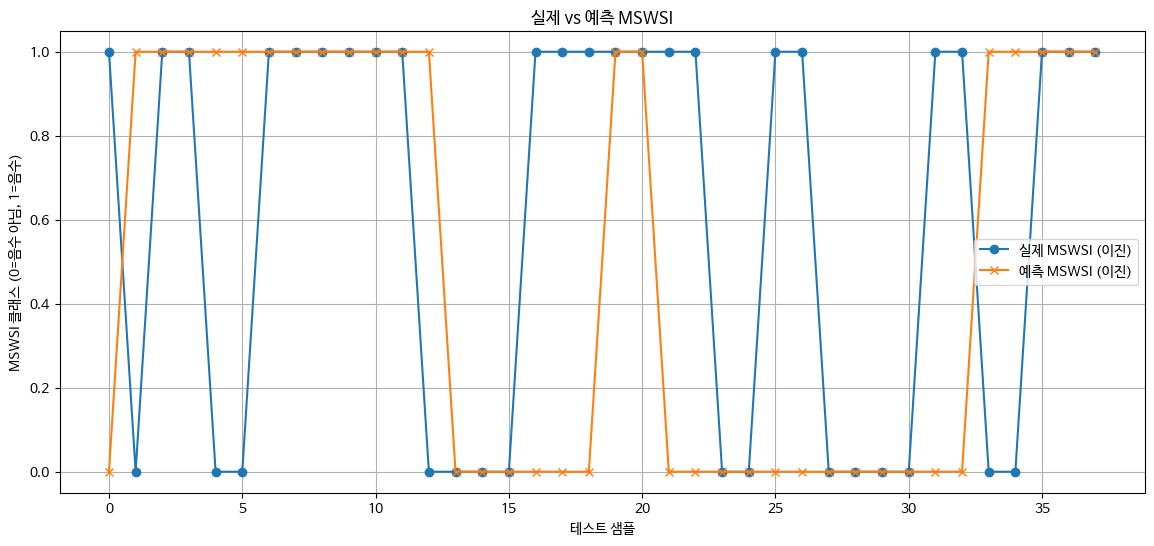

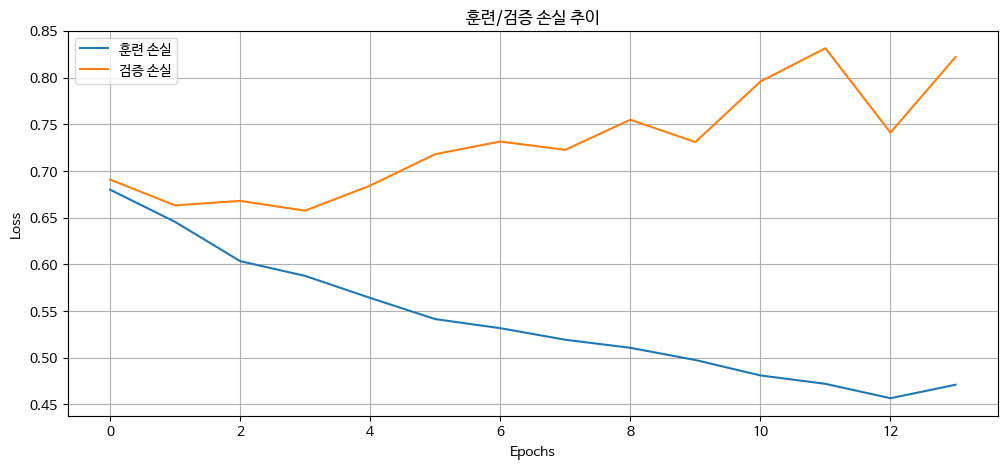

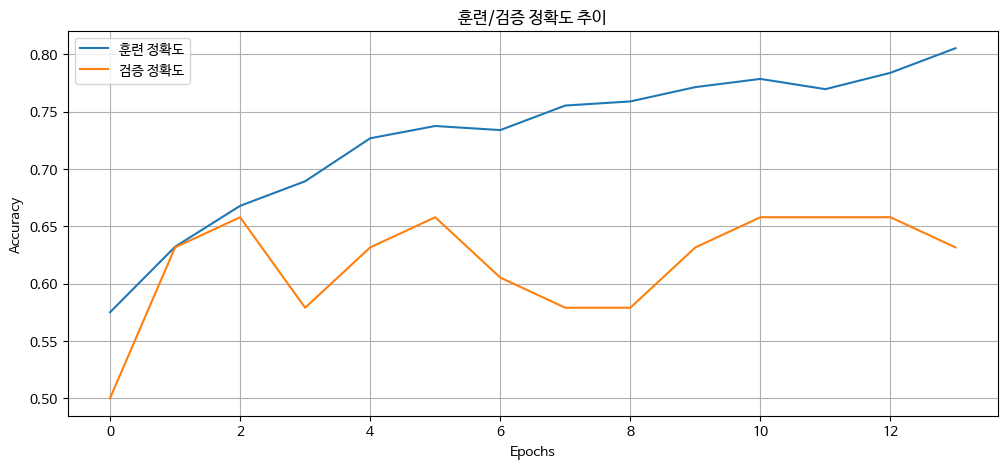

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# 데이터 불러오기 & 타겟 변환
# ---------------------------
df['mswsi_binary'] = df['가뭄(MSWSI)'].apply(lambda x: 1 if x < 0 else 0)

X = df.drop(columns=['가뭄(MSWSI)', 'mswsi_binary'])
y = df['mswsi_binary'].values

# ---------------------------
# Train/Test 분할 (시계열)
# ---------------------------
test_size = 52
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# ---------------------------
# 스케일링
# ---------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# ---------------------------
# 시퀀스 생성 (time_steps)
# ---------------------------
def create_sequences(X, y, time_steps=14):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:i+time_steps].values)
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 14
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled, y_test, time_steps)

# ---------------------------
# 클래스 가중치
# ---------------------------
classes = np.unique(y_train_seq)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weight_dict = dict(zip(classes, class_weights))
print("클래스 가중치:", class_weight_dict)

# ---------------------------
# LSTM 모델 정의
# ---------------------------
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ---------------------------
# 학습
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=8,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# 예측 & 평가
# ---------------------------
y_pred_prob = model.predict(X_test_seq)
y_pred_class = (y_pred_prob > 0.5).astype(int)

acc  = accuracy_score(y_test_seq, y_pred_class)
prec = precision_score(y_test_seq, y_pred_class, zero_division=0)
rec  = recall_score(y_test_seq, y_pred_class, zero_division=0)
f1   = f1_score(y_test_seq, y_pred_class, zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# ---------------------------
# 시각화: 실제 vs 예측
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_seq, label="실제 MSWSI (이진)", marker='o')
plt.plot(y_pred_class, label="예측 MSWSI (이진)", marker='x')
plt.title("실제 vs 예측 MSWSI")
plt.xlabel("테스트 샘플")
plt.ylabel("MSWSI 클래스 (0=음수 아님, 1=음수)")
plt.legend()
plt.grid(True)
plt.show()


# ---------------------------
# 학습 손실 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title("훈련/검증 손실 추이")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 정확도 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title("훈련/검증 정확도 추이")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


2차

클래스 가중치: {np.int64(0): np.float64(1.1425619834710743), np.int64(1): np.float64(0.8890675241157556)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.5147 - loss: 0.6922 - val_accuracy: 0.5161 - val_loss: 0.6708
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 0.6508 - loss: 0.6353 - val_accuracy: 0.5484 - val_loss: 0.6774
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6351 - loss: 0.6332 - val_accuracy: 0.4839 - val_loss: 0.6755
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6138 - loss: 0.6458 - val_accuracy: 0.6452 - val_loss: 0.6569
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6622 - loss: 0.6108 - val_accuracy: 0.6129 - val_loss: 0.6581
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7119 - loss: 0.5857 - val_accuracy: 0.6774 - val_loss: 0.6318
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7203 - loss: 0.5464 - val_accuracy: 0.6774 - val_loss: 0.6299
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7034 - loss: 0.5444 - val_accuracy

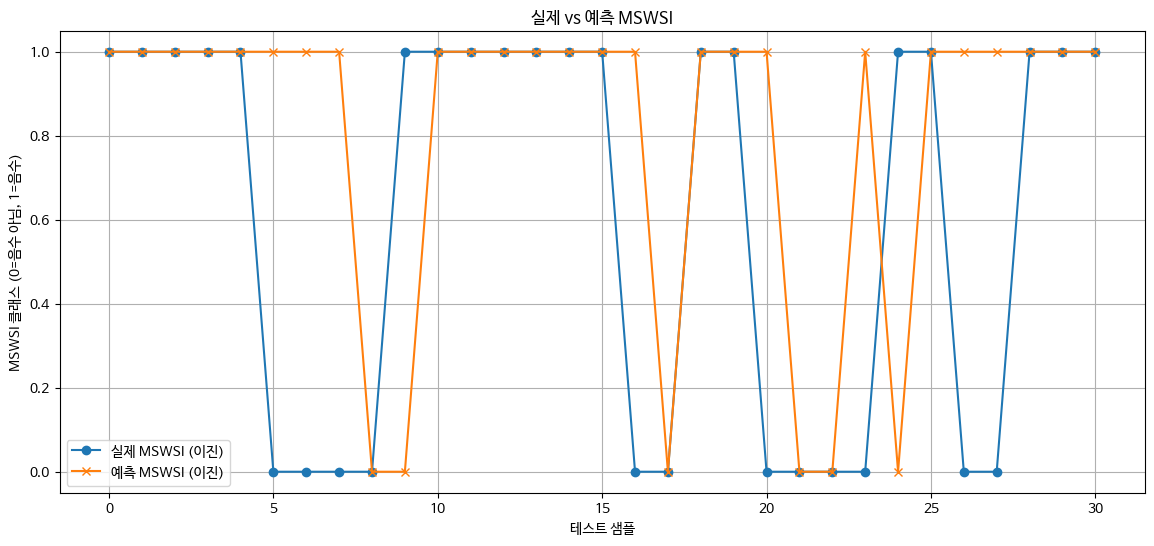

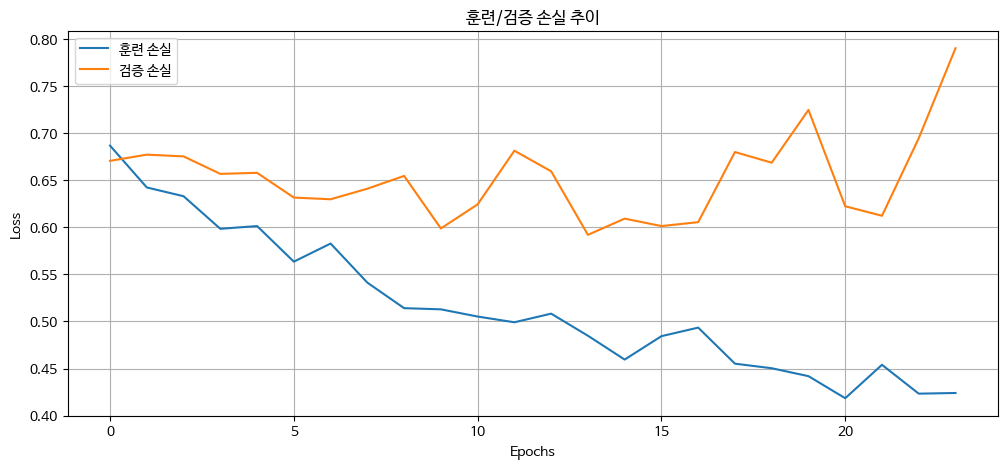

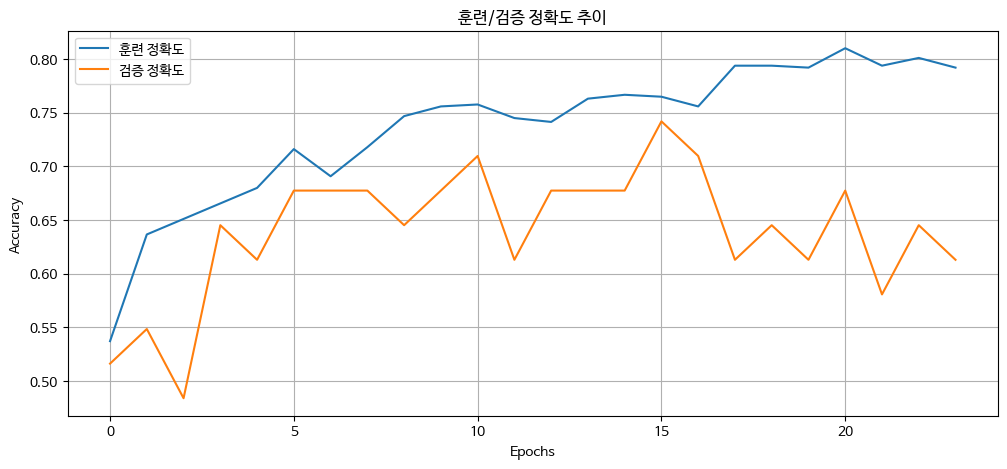

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------
# 데이터 불러오기 & 타겟 변환
# ---------------------------
df['mswsi_binary'] = df['가뭄(MSWSI)'].apply(lambda x: 1 if x < 0 else 0)
X = df.drop(columns=['가뭄(MSWSI)', 'mswsi_binary'])
y = df['mswsi_binary'].values

# ---------------------------
# Train/Test 분할 (시계열)
# ---------------------------
test_size = 52
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# ---------------------------
# 스케일링
# ---------------------------
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# ---------------------------
# 시퀀스 생성 (time_steps=21)
# ---------------------------
def create_sequences(X, y, time_steps=21):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:i+time_steps].values)
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 21
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_test_seq, y_test_seq   = create_sequences(X_test_scaled, y_test, time_steps)

# ---------------------------
# 클래스 가중치
# ---------------------------
classes = np.unique(y_train_seq)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_seq)
class_weight_dict = dict(zip(classes, class_weights))
print("클래스 가중치:", class_weight_dict)

# ---------------------------
# LSTM 모델 정의 (은닉 256, Dense 128->64)
# ---------------------------
model = Sequential([
    LSTM(256, activation='tanh', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # 이진 분류
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ---------------------------
# 학습
# ---------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=100,
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# ---------------------------
# 예측 & 분류 성능 평가
# ---------------------------
y_pred_prob = model.predict(X_test_seq)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("\n=== 상세 분류 리포트 ===")
print(classification_report(
    y_test_seq,
    y_pred_class,
    target_names=["비가뭄(0)", "가뭄(1)"]  # 라벨값과 의미를 같이 표시
))


# ---------------------------
# 시각화: 실제 vs 예측
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test_seq, label="실제 MSWSI (이진)", marker='o')
plt.plot(y_pred_class, label="예측 MSWSI (이진)", marker='x')
plt.title("실제 vs 예측 MSWSI")
plt.xlabel("테스트 샘플")
plt.ylabel("MSWSI 클래스 (0=음수 아님, 1=음수)")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 손실 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='훈련 손실')
plt.plot(history.history['val_loss'], label='검증 손실')
plt.title("훈련/검증 손실 추이")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 학습 정확도 그래프
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='훈련 정확도')
plt.plot(history.history['val_accuracy'], label='검증 정확도')
plt.title("훈련/검증 정확도 추이")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# 2025년 예측

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5398 - loss: 0.6939 - val_accuracy: 0.5962 - val_loss: 0.6957
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6287 - loss: 0.6543 - val_accuracy: 0.5962 - val_loss: 0.7166
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6424 - loss: 0.6239 - val_accuracy: 0.5385 - val_loss: 0.6881
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7026 - loss: 0.5848 - val_accuracy: 0.5962 - val_loss: 0.6543
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7029 - loss: 0.5694 - val_accuracy: 0.6923 - val_loss: 0.6250
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7548 - loss: 0.5311 - val_accuracy: 0.6923 - val_loss: 0.6200
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7297 - loss: 0.5078 - val_accuracy: 0.6154 - val_loss: 0.6969
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.7304 - loss: 0.5267 - val_accuracy: 0.5962 - val_loss: 0.

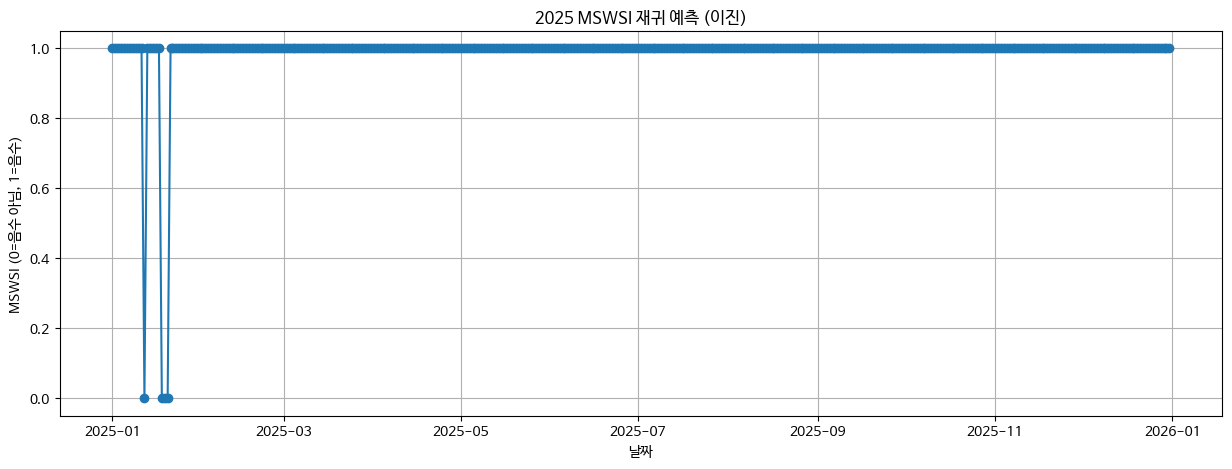

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# ---------------------------
# 데이터 불러오기 & 스케일링
# ---------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
df = df.set_index('관측일시')

# MSWSI 이진화: 음수=1, 아니면 0
df['mswsi_binary'] = df['가뭄(MSWSI)'].apply(lambda x: 1 if x < 0 else 0)

X = df.drop(columns=['가뭄(MSWSI)', 'mswsi_binary'])
y = df['mswsi_binary'].values

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# ---------------------------
# 시퀀스 생성 함수
# ---------------------------
def create_sequences(X, y, time_steps=21):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X.iloc[i:i+time_steps].values)
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

time_steps = 21
X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

# ---------------------------
# LSTM 모델 정의 (성능 좋은 구조 그대로)
# ---------------------------
model = Sequential([
    LSTM(256, activation='tanh', input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ---------------------------
# 학습 (마지막 52개 제외)
# ---------------------------
train_size = len(X_seq) - 52
X_train_seq, y_train_seq = X_seq[:train_size], y_seq[:train_size]
X_val_seq, y_val_seq = X_seq[train_size:], y_seq[train_size:]

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=16,
    verbose=1
)

# ---------------------------
# 2025년 재귀적 예측
# ---------------------------
# 2025년 날짜 생성 (주간 예시)
future_dates = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')  # 일 단위
future_preds = []

# 마지막 학습 시퀀스 가져오기
last_seq = X_scaled.iloc[-time_steps:].values

for _ in range(len(future_dates)):
    pred_prob = model.predict(last_seq.reshape(1, time_steps, X_scaled.shape[1]))
    pred_class = (pred_prob > 0.5).astype(int)[0][0]
    future_preds.append(pred_class)

    # 다음 입력 시퀀스 업데이트
    # 피처는 그대로 두고 시퀀스 이동
    new_row = last_seq[-1].copy()  # 단순 유지
    last_seq = np.vstack([last_seq[1:], new_row])

# ---------------------------
# 결과 출력
# ---------------------------
future_df = pd.DataFrame({'date': future_dates, 'predicted_mswsi': future_preds})
print(future_df.head(20))

# 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(future_df['date'], future_df['predicted_mswsi'], marker='o')
plt.title("2025 MSWSI 재귀 예측 (이진)")
plt.xlabel("날짜")
plt.ylabel("MSWSI (0=음수 아님, 1=음수)")
plt.grid(True)
plt.show()
